## load libraries

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import numpy.ma as ma
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
from sklearn import preprocessing
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import *
from scipy.stats import zscore, norm
from sklearn import linear_model
#from isc_reorder import isc_reorder
#from isc_recall import isc_recall
import pickle

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

%autosave 5
%matplotlib inline

Autosaving every 5 seconds


## set variables

In [2]:
data_dir = '/Users/barnettlab/Documents/cartoon_recall/fmri_data/'
analysis_dir = '/Users/barnettlab/Documents/cartoon_recall/fmri_data/'
roi_list = pd.read_excel(analysis_dir+'roilist.xlsx')
movie_list = ['barmaid','bluestreets']
subjlist_full = pd.read_excel(analysis_dir+'subjlist.xlsx')
hc_list = ['_L_ant_hippo.nii.gz','_L_post_hippo.nii.gz','_R_ant_hippo.nii.gz','_R_post_hippo.nii.gz']
event_boundaries = pd.read_excel(analysis_dir+'fmri_recall_event_boundaries_14events_each.xlsx')

## import node names
glasser_nodes=pd.read_excel('hc_glasser_nodes.xlsx')
recall_scoring = pd.read_excel(analysis_dir+'event detail scoring 14 events.xlsx')

num_subs = 24

In [3]:
# load in univariate activity

boundary_diff_hc = np.load('boundary_diff.npy')
boundary_diff_pmn = np.load('boundary_diff_pmn.npy')
boundary_diff_mtn = np.load('boundary_diff_mtn.npy')
boundary_diff_atn = np.load('boundary_diff_atn.npy')
boundary_diff_mpn = np.load('boundary_diff_mpn.npy')

In [4]:
indsort_sub = np.loadtxt(analysis_dir+'indsort_subnetworks.txt')
indsort_sub=indsort_sub.astype('int32')
for i in range(len(indsort_sub)):
    indsort_sub[i] = indsort_sub[i] -1

indsort_sub =np.append(indsort_sub,[358,359,360,361])

In [5]:
## make array of subject ids
subject_list = subjlist_full['subj_id'].unique()
## set net labels
net_label = ['VIS','SOM-MOT','SAL1','DAN1','SAL2','DAN2','LANG','FPN','AUD','ATN','MTN','PMN','MPN','antHC','postHC']

In [6]:
# event boundaries: first barmaid, then bluestreets
barmaid_boundaries = np.array([[0,     58,    97,    160,   189,   300, 350, 470, 507, 552, 619, 695, 772, 871, 1006]])
# convert seconds to TRs and shift 5 TRs to account for hemodynamic response
barmaid_boundaries = ((barmaid_boundaries)/1.22)+5

bluestreets_boundaries = np.array([[0,    75,   150,   226,   307, 381, 444, 526, 578, 665, 756, 828, 853,873,982]])
# convert seconds to TRs and shift 5 TRs to account for hemodynamic response
bluestreets_boundaries = ((bluestreets_boundaries)/1.22)+5

## load in fc data

In [7]:
barmaid_movie_fc_data = np.load(analysis_dir+'barmaid_movie_data_extracted_full.npy')
bluestreets_movie_fc_data = np.load(analysis_dir+'bluestreets_movie_data_extracted_full.npy')

## view example timecourse

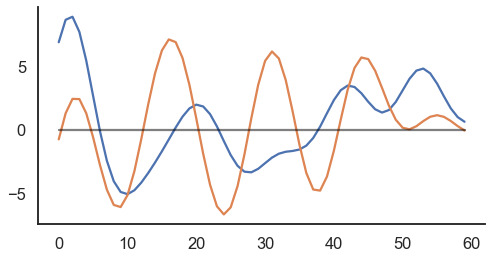

In [8]:
sns.set_theme('talk')
sns.set_style('white')

plt.figure(figsize=(8,4))
sns.lineplot(data =bluestreets_movie_fc_data[2,31,100:160])
sns.lineplot(data=bluestreets_movie_fc_data[2,360,100:160])


zero_line=[]
for x in range(60):
    zero_line.append(0) 

plt.plot(zero_line, color = 'black', alpha = .5)
sns.despine()

## calc fc for a sliding window across events

In [9]:
num_subs = 24

In [10]:
net_label_sep_hc = ['VIS',
 'SOM-MOT',
 'SAL1',
 'DAN1',
 'SAL2',
 'DAN2',
 'LANG',
 'FPN',
 'AUD',
 'ATN',
 'MTN',
 'PMN',
 'MPN',
 'LantHC',
 'LpostHC',
 'RantHC',
 'RpostHC']

In [11]:
net_selection = [10,11,12,13,14,15]

In [13]:
# set up sliding window loop
## 17 TRs is the smallest event length, so we will go through 17 steps and check to see how fc relates to subsequent memory

In [15]:
# from first to last window of an event

In [16]:
window_size = 10
num_windows = 17
num_subs = 24

for window in range(num_windows):
    mov = 0 ## barmaid
    event_list = range(0,14)
    subject = []
    event_recalled = []
    central_d = []
    peri_d = []
    movie = []
    event_length = []
    delay = []
    events=[]
    fc = []
    net1_label=[]
    net2_label = []
    event_label = []

    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(barmaid_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(barmaid_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(event_length_tracker)
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    mov = 1   # bluestreets movie            
    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(bluestreets_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(bluestreets_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    delay = np.reshape(delay,np.shape(delay)[0])
    event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
    peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
    central_d = np.reshape(central_d,np.shape(central_d)[0])

    data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
    columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

    sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


    sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
    sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
    sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

    sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [ ]:
# add in the next 10 windows into the subsequent event to see where the effect goes

In [17]:
window_size = 10
num_windows = 17
num_subs = 24

for window in range(18,27):
    mov = 0 ## barmaid
    event_list = range(0,14)
    subject = []
    event_recalled = []
    central_d = []
    peri_d = []
    movie = []
    event_length = []
    delay = []
    events=[]
    fc = []
    net1_label=[]
    net2_label = []
    event_label = []

    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(barmaid_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(barmaid_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(event_length_tracker)
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    mov = 1   # bluestreets movie            
    for sub in range(num_subs):
        temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
        for event in range(14):
            event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
            temp2 = temp1[temp1['event']==event+1]
            start = int(np.round(bluestreets_boundaries[0,event]))-window_size
            if start<0:
                 start=0
            else:
                start=start
            end = int(np.round(bluestreets_boundaries[0,event]))+window_size
            start_window = int(start +np.round((event_length_tracker)/num_windows*window))
            end_window = int(end + np.round((event_length_tracker)/num_windows*window))
            event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
            event_fc = np.corrcoef(event_fc_data)
            event_fc_z= np.arctanh(event_fc)
            for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
                event_fc_z[x,x]=np.nan
            for net1 in range(6):
                for net2 in range(6):
                    net1_label.append(net_label[net_selection[net1]-1])
                    net2_label.append(net_label[net_selection[net2]-1])
                    net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                    fc.append(np.nanmean(net_to_net_fc.flatten()))
                    subject.append(subject_list[sub])
                    events.append(event_list[event]+1)
                    event_label.append(event_list[event]+1)
                    delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                    movie.append(movie_list[mov])
                    event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                    event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                    peri_d.append(temp2['total pd'].values)
                    central_d.append(temp2['total cd'].values)

    delay = np.reshape(delay,np.shape(delay)[0])
    event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
    peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
    central_d = np.reshape(central_d,np.shape(central_d)[0])

    data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
    columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

    sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


    sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
    sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
    sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
    sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

    sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [ ]:
# delete the below section?

In [22]:
window_size = 10
num_windows = 17
num_subs = 24

window=17
mov = 0 ## barmaid
event_list = range(0,14)
subject = []
event_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
events=[]
fc = []
net1_label=[]
net2_label = []
event_label = []

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        event_length_tracker = int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event]))
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(barmaid_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(barmaid_boundaries[0,event]))+window_size
        start_window = int(start +np.round((event_length_tracker)/num_windows*window))
        end_window = int(end + np.round((event_length_tracker)/num_windows*window))
        event_fc_data = barmaid_movie_fc_data[sub,:,start_window:end_window]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
            event_fc_z[x,x]=np.nan
        for net1 in range(6):
            for net2 in range(6):
                net1_label.append(net_label[net_selection[net1]-1])
                net2_label.append(net_label[net_selection[net2]-1])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                event_length.append(event_length_tracker)
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

mov = 1   # bluestreets movie            
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        event_length_tracker = int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event]))
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(bluestreets_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(bluestreets_boundaries[0,event]))+window_size
        start_window = int(start +np.round((event_length_tracker)/num_windows*window))
        end_window = int(end + np.round((event_length_tracker)/num_windows*window))
        event_fc_data = bluestreets_movie_fc_data[sub,:,start_window:end_window]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):  ## zero out the diagonal
            event_fc_z[x,x]=np.nan
        for net1 in range(6):
            for net2 in range(6):
                net1_label.append(net_label[net_selection[net1]-1])
                net2_label.append(net_label[net_selection[net2]-1])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net_selection[net1]][:,glasser_nodes['community_sublabels']==net_selection[net2]]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

delay = np.reshape(delay,np.shape(delay)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d])
columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','event_recalled','peri_d','central_d']

sliding_window_encoding_fc_recall_pd = pd.DataFrame(data =data3, columns = columns3)


sliding_window_encoding_fc_recall_pd['fc'] = sliding_window_encoding_fc_recall_pd['fc'].astype('float')
sliding_window_encoding_fc_recall_pd['event_length'] = sliding_window_encoding_fc_recall_pd['event_length'].astype('float')
sliding_window_encoding_fc_recall_pd['peri_d'] = sliding_window_encoding_fc_recall_pd['peri_d'].astype('float')
sliding_window_encoding_fc_recall_pd['central_d'] = sliding_window_encoding_fc_recall_pd['central_d'].astype('float')
sliding_window_encoding_fc_recall_pd['event_recalled'] = sliding_window_encoding_fc_recall_pd['event_recalled'].astype('float')
sliding_window_encoding_fc_recall_pd['delay'] = sliding_window_encoding_fc_recall_pd['delay'].astype('str')

sliding_window_encoding_fc_recall_pd.to_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

In [77]:
fc_estimate = []
stdev_estimate = []
window=17

sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
#model_data3['boundary_diff_mtn'] =boundary_diff_mtn
#model_data3['boundary_diff_mpn'] =boundary_diff_mpn
#model_data3['boundary_diff_atn'] =boundary_diff_atn

model = smf.mixedlm('fc~event_recalled*boundary_diff_hc*boundary_diff_pmn*net1_label', model_data3,groups = 'subject', missing='drop')
mdf = model.fit()

fc_estimate.append(mdf.params[2])
stdev_estimate.append(mdf.bse[2])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [20]:
model_data3.to_csv(data_dir+'enc_fc_hc_pmn_pd.csv')

<AxesSubplot:xlabel='net1_label', ylabel='fc'>

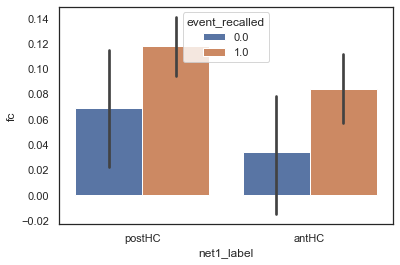

In [82]:
sns.barplot(hue = 'event_recalled', y = 'fc',x = 'net1_label', data = model_data3[model_data3['delay']==0])

<AxesSubplot:xlabel='net1_label', ylabel='fc'>

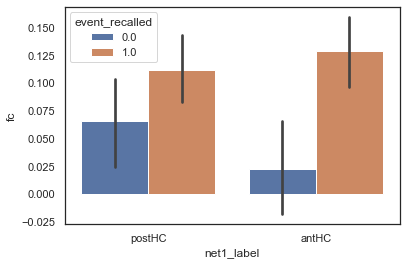

In [83]:
sns.barplot(hue = 'event_recalled', y = 'fc',x = 'net1_label', data = model_data3[model_data3['delay']==2])

In [884]:
sliding_window_encoding_fc_recall['event_length']= sliding_window_encoding_fc_recall['event_length']+1

In [887]:
np.max(sliding_window_encoding_fc_recall['event_length'])

112.0

In [793]:
end_window

724

In [8]:
fc_estimate

[0.06803095319720913]

In [338]:
model_data3['event_recalled'].unique()

array([1., 0.])

In [331]:
print(mdf.summary())

                                      Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     fc     
No. Observations:                     1344                        Method:                                 REML   
No. Groups:                           24                          Scale:                                  0.0459 
Min. group size:                      56                          Log-Likelihood:                         74.9895
Max. group size:                      56                          Converged:                              Yes    
Mean group size:                      56.0                                                                       
-----------------------------------------------------------------------------------------------------------------
                                                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------

In [531]:
window = 0
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']


In [13]:
DMN_nets = ['PMN','MPN','MTN','ATN']

In [68]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)

    stdev_estimate_all.append(stdev_estimate)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

In [116]:

sns.set_style('white')

plt.plot(np.transpose(fc_estimate_all[0]))
#plt.plot(np.transpose(fc_estimate_all[1]),alpha = 0.25)
#plt.plot(np.transpose(fc_estimate_all[2]),alpha = 0.25)
#plt.plot(np.transpose(fc_estimate_all[3]),alpha = 0.25)

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('Window Center \n (% into event)',fontsize=15)
plt.ylabel('FC difference between \n recalled and forgotten',fontsize=15)
plt.legend(['HC-PMN FC'], bbox_to_anchor=(.85,.5, .5, .5))
#plt.legend(['PMN', 'MPN','MTN','ATN'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

#plt.fill_between(x_value, np.array(fc_estimate_all)-stdev_estimate_all, np.array(fc_estimate_all)+stdev_estimate_all,alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_all[0])-stdev_estimate_all[0], np.array(fc_estimate_all[0])+stdev_estimate_all[0],alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[1])-stdev_estimate_all[1], np.array(fc_estimate_all[1])+stdev_estimate_all[1],alpha=0.2)
#plt.fill_between(x_value, np.array(fc_estimate_all[2])-stdev_estimate_all[2], np.array(fc_estimate_all[2])+stdev_estimate_all[2],alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[3])-stdev_estimate_all[3], np.array(fc_estimate_all[3])+stdev_estimate_all[3],alpha=0.25)


locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


sns.despine()

plt.savefig(analysis_dir+'hc-net-fc-sliding-window-recall.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

NameError: name 'fc_estimate_all' is not defined

In [170]:
model_data3

,Unnamed: 0,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d,fc_mc,boundary_diff_hc,boundary_diff_pmn,boundary_diff_mtn,boundary_diff_mpn,boundary_diff_atn
26,26,sub-000,barmaid,1,0,0.428252,antHC,PMN,1,48.0,1.0,6.0,4.0,0.219694,0.442102,4.689264,5.741509,1.323280,0.604927
62,62,sub-000,barmaid,2,0,-0.940407,antHC,PMN,2,32.0,0.0,0.0,0.0,-1.148965,0.050252,1.443929,0.606908,0.672707,1.690058
98,98,sub-000,barmaid,3,0,0.557387,antHC,PMN,3,51.0,1.0,5.0,3.5,0.348829,0.468280,4.324824,7.930578,-2.089690,-1.563153
134,134,sub-000,barmaid,4,0,0.353597,antHC,PMN,4,24.0,1.0,4.5,1.0,0.145038,-0.676956,0.227153,0.516855,-0.439179,-1.053588
170,170,sub-000,barmaid,5,0,-0.186736,antHC,PMN,5,91.0,1.0,2.0,1.0,-0.395294,0.647896,1.510975,6.883676,-0.866525,-1.678982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24044,24044,sub-130,bluestreets,10,0,-0.381804,postHC,PMN,10,75.0,1.0,3.5,4.0,-0.217345,2.404233,4.688989,5.381995,3.198278,4.170082
24080,24080,sub-130,bluestreets,11,0,0.591700,postHC,PMN,11,59.0,1.0,4.0,4.5,0.756159,-0.727889,0.693974,0.294536,1.181265,-0.917072
24116,24116,sub-130,bluestreets,12,0,0.591700,postHC,PMN,12,20.0,1.0,0.0,1.5,0.756159,-0.047684,1.289089,2.339128,-0.087856,0.202718
24152,24152,sub-130,bluestreets,13,0,0.188323,postHC,PMN,13,17.0,0.0,0.0,0.0,0.352782,-4.559969,-0.045179,-1.292732,-2.954231,-2.464035


In [18]:
net = 0   
fc_estimate = []
bse_estimate = []
pv= []
z_scores = []
for window in range(27):


    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])
    model_data3 = model_data3
    

    model = smf.mixedlm('fc~event_recalled', model_data3,
                        groups = 'subject', missing='drop')
    mdf = model.fit(method = 'lbfgs')

    fc_estimate.append(mdf.params[1])
    bse_estimate.append(mdf.bse[1])
    pv.append(mdf.pvalues[1])
    z_scores.append(mdf.tvalues[1])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

In [19]:
pv

[0.7056326972066389,
 0.2916240192875823,
 0.2192041177578522,
 0.2698711481335314,
 0.3461400504130012,
 0.3135473881477093,
 0.08153670716562238,
 0.03419716519587686,
 0.004473608800499831,
 0.053549958870386515,
 0.027533548134578523,
 0.01806397679870275,
 0.22220745090522986,
 0.5529563869188092,
 0.04266482152837422,
 0.009789878153456465,
 0.002178973572070019,
 0.001018858704078394,
 0.006624187976953468,
 0.021747823920659517,
 0.2828416412972242,
 0.8352370010789781,
 0.9592572311634591,
 0.9333280123947163,
 0.9862438879995667,
 0.6221055237693066,
 0.8800157665295576]

In [20]:
np.where(np.array(pv)<.1)

(array([ 6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19]),)

In [240]:
pv[4:11]

[0.3461400504130012,
 0.3135473881477093,
 0.08153670716562238,
 0.03419716519587686,
 0.004473608800499831,
 0.053549958870386515,
 0.027533548134578523]

In [213]:
mdf.tvalues

Intercept                     NaN
event_recalled[T.1.0]   -0.375307
movie[T.bluestreets]    -0.812421
subject Var                   NaN
dtype: float64

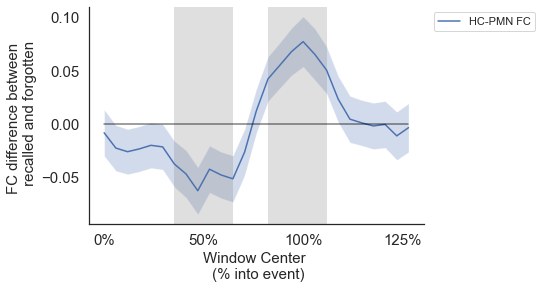

In [27]:

sns.set_style('white')
#sns.set_theme('notebook')
fig, ax = plt.subplots()
plt.plot(np.transpose(fc_estimate))
#plt.plot(np.transpose(fc_estimate_all[1]),alpha = 0.25)
#plt.plot(np.transpose(fc_estimate_all[2]),alpha = 0.25)
#plt.plot(np.transpose(fc_estimate_all[3]),alpha = 0.25)

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('Window Center \n (% into event)',fontsize=15)
plt.ylabel('FC difference between \n recalled and forgotten',fontsize=15)
plt.legend(['HC-PMN FC'], bbox_to_anchor=(.85,.5, .5, .5))
#plt.legend(['PMN', 'MPN','MTN','ATN'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

#plt.fill_between(x_value, np.array(fc_estimate_all)-stdev_estimate_all, np.array(fc_estimate_all)+stdev_estimate_all,alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate)-bse_estimate, np.array(fc_estimate)+bse_estimate,alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[1])-stdev_estimate_all[1], np.array(fc_estimate_all[1])+stdev_estimate_all[1],alpha=0.2)
#plt.fill_between(x_value, np.array(fc_estimate_all[2])-stdev_estimate_all[2], np.array(fc_estimate_all[2])+stdev_estimate_all[2],alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[3])-stdev_estimate_all[3], np.array(fc_estimate_all[3])+stdev_estimate_all[3],alpha=0.25)
ax.axvspan(14, 19, alpha=0.25, color='gray',linewidth = 0)
ax.axvspan(6, 11, alpha=0.25, color='gray',linewidth = 0)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


sns.despine()

plt.savefig(analysis_dir+'hc-net-fc-sliding-window-recall-shaded.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [12]:
np.where(pv<.1)

NameError: name 'pv' is not defined

In [134]:
model_data3

,Unnamed: 0,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d,fc_mc,boundary_diff_hc,boundary_diff_pmn,boundary_diff_mtn,boundary_diff_mpn,boundary_diff_atn
26,26,sub-000,barmaid,1,0,0.428252,antHC,PMN,1,48.0,1.0,6.0,4.0,0.219694,0.442102,4.689264,5.741509,1.323280,0.604927
62,62,sub-000,barmaid,2,0,-0.940407,antHC,PMN,2,32.0,0.0,0.0,0.0,-1.148965,0.050252,1.443929,0.606908,0.672707,1.690058
98,98,sub-000,barmaid,3,0,0.557387,antHC,PMN,3,51.0,1.0,5.0,3.5,0.348829,0.468280,4.324824,7.930578,-2.089690,-1.563153
134,134,sub-000,barmaid,4,0,0.353597,antHC,PMN,4,24.0,1.0,4.5,1.0,0.145038,-0.676956,0.227153,0.516855,-0.439179,-1.053588
170,170,sub-000,barmaid,5,0,-0.186736,antHC,PMN,5,91.0,1.0,2.0,1.0,-0.395294,0.647896,1.510975,6.883676,-0.866525,-1.678982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24044,24044,sub-130,bluestreets,10,0,-0.381804,postHC,PMN,10,75.0,1.0,3.5,4.0,-0.217345,2.404233,4.688989,5.381995,3.198278,4.170082
24080,24080,sub-130,bluestreets,11,0,0.591700,postHC,PMN,11,59.0,1.0,4.0,4.5,0.756159,-0.727889,0.693974,0.294536,1.181265,-0.917072
24116,24116,sub-130,bluestreets,12,0,0.591700,postHC,PMN,12,20.0,1.0,0.0,1.5,0.756159,-0.047684,1.289089,2.339128,-0.087856,0.202718
24152,24152,sub-130,bluestreets,13,0,0.188323,postHC,PMN,13,17.0,0.0,0.0,0.0,0.352782,-4.559969,-0.045179,-1.292732,-2.954231,-2.464035


In [145]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                  MixedLM       Dependent Variable:       fc    
No. Observations:       1248          Method:                   REML  
No. Groups:             24            Scale:                    0.1345
Min. group size:        52            Log-Likelihood:           inf   
Max. group size:        52            Converged:                Yes   
Mean group size:        52.0                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.000                                    
event_recalled[T.1.0]       -0.011    0.034 -0.330 0.742 -0.078  0.056
delay                       -0.011    0.018 -0.626 0.531 -0.047  0.024
event_recalled[T.1.0]:delay -0.003    0.023 -0.128 0.898 -0.047  0.041
subject Var                  0.000                                    
======================================================================

"""

In [89]:
model_data3 = model_data3.reset_index()
index_test = np.array(model_data3.index)

In [95]:
event_recalled = model_data3['event_recalled'].values

In [90]:
index_test

array([   0,    1,    2, ..., 1341, 1342, 1343])

In [91]:
random.shuffle(index_test)

In [94]:
event_recalled

array([1., 1., 1., ..., 1., 0., 1.])

In [98]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
import random


### THESE SHOULD BE 1-tailed based on our a priori hypotheses


In [106]:
net = 0   

max_cluster_perm = []
for perm in range(1000):
    random.shuffle(index_test)
    pv= []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])
        model_data3['event_recalled'] = event_recalled[index_test]
        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        pv.append(mdf.pvalues[1])
        
    sig_spots = np.where(np.array(pv)<.1)
    sig_spots = sig_spots[0]
    current_cluster = 1
    max_cluster = 1
    for i in range(np.size(sig_spots)-1):
        if sig_spots[i]-sig_spots[i+1] == -1:
            current_cluster =current_cluster+1
            if current_cluster>max_cluster:
                max_cluster = current_cluster
        if sig_spots[i]-sig_spots[i+1] != -1:
            current_cluster =1
    max_cluster_perm.append(max_cluster)

In [243]:
np.size(np.where(np.array(max_cluster_perm)>3))/1000

0.064

In [105]:
max_cluster_perm_1 = max_cluster_perm

In [122]:
max_cluster_perm_1

[1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 2,
 1,
 4,
 1,
 2,
 1,
 2,
 3,
 3,
 1,
 1]

(array([770.,  70.,  35.,  15.,   5.,   6.,   1.,   0.,   1.,   1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

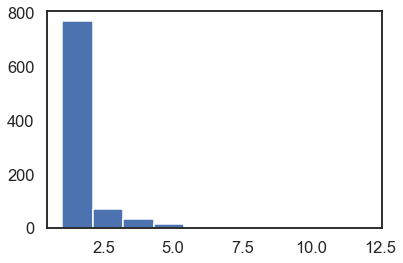

In [107]:
plt.hist(max_cluster_perm)

In [ ]:

pv

In [83]:
model_data3 = model_data3.reset_index()

In [88]:
np.array(model_data3.index)

array([   0,    1,    2, ..., 1341, 1342, 1343])

In [39]:
event_recalled = model_data3['event_recalled'].values

In [41]:
event_recalled = np.array(event_recalled)

In [81]:
np.shape(event_recalled)

(1344,)

In [43]:
random.shuffle(event_recalled)

In [44]:
event_recalled

array([1., 1., 1., ..., 1., 0., 1.])

In [45]:
model_data3['event_recalled'] = event_recalled

In [48]:
model = smf.mixedlm('fc~event_recalled', model_data3,
                    groups = 'subject', missing='drop')
mdf = model.fit(method = 'lbfgs')

p_perm.append(mdf.pvalues[1])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [49]:
p_perm

[0.7909945106659829]

In [54]:
sig_spots = np.where(np.array(pv)<.05)

In [67]:
sig_spots = sig_spots[0]

In [70]:
sig_spots

array([ 7,  8, 10, 11, 14, 15, 16, 17, 18, 19])

In [76]:
current_cluster = 1
max_cluster = 1
for i in range(np.size(sig_spots)-1):
    if sig_spots[i]-sig_spots[i+1] == -1:
        current_cluster =current_cluster+1
        if current_cluster>max_cluster:
            max_cluster = current_cluster
    if sig_spots[i]-sig_spots[i+1] != -1:
        current_cluster =1

In [77]:
max_cluster

6

In [60]:
np.size(sig_spots)-1

9

In [ ]:
data =  model_data3[model_data3['net1_label']=='antHC']

<AxesSubplot:xlabel='event_recalled', ylabel='boundary_diff_pmn'>

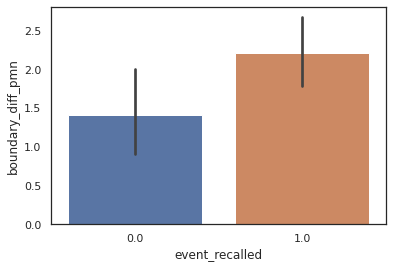

In [189]:
sns.barplot(x = 'event_recalled', y ='boundary_diff_pmn', data =  model_data3[model_data3['net1_label']=='antHC'])

In [ ]:
## repeat with windows longer than 40TRs

In [84]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])
        model_data3 = model_data3[model_data3['event_length']>39]

        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)
    stdev_estimate_all.append(stdev_estimate)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

In [71]:
import matplotlib

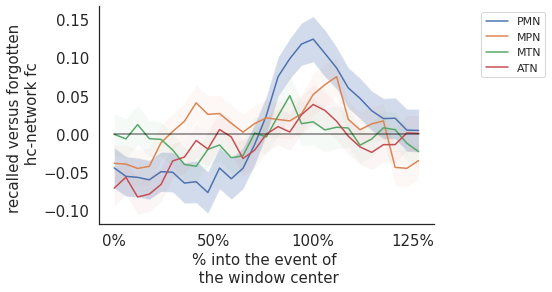

In [85]:
sns.set_theme('notebook')
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 45}

matplotlib.rc('font', **font)
plt.plot(np.transpose(fc_estimate_all))

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('recalled versus forgotten \n hc-network fc',fontsize=15)
plt.legend(['PMN', 'MPN','MTN','ATN'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

#plt.fill_between(x_value, np.array(fc_estimate_all)-stdev_estimate_all, np.array(fc_estimate_all)+stdev_estimate_all,alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_all[0])-stdev_estimate_all[0], np.array(fc_estimate_all[0])+stdev_estimate_all[0],alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_all[1])-stdev_estimate_all[1], np.array(fc_estimate_all[1])+stdev_estimate_all[1],alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_all[2])-stdev_estimate_all[2], np.array(fc_estimate_all[2])+stdev_estimate_all[2],alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_all[3])-stdev_estimate_all[3], np.array(fc_estimate_all[3])+stdev_estimate_all[3],alpha=0.05)


locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

In [232]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

        model = smf.mixedlm('fc~event_recalled', model_data3[model_data3['delay'] == 0],
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)
    stdev_estimate_all.append(stdev_estimate)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at 

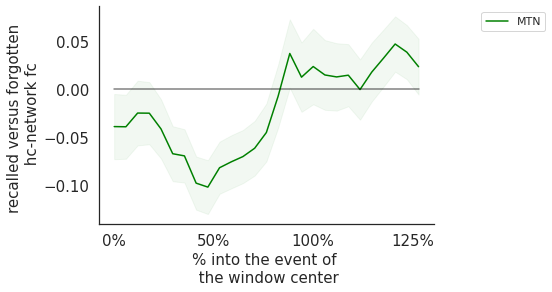

In [233]:
sns.set_theme('notebook')
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 45}

matplotlib.rc('font', **font)
plt.plot(np.transpose(fc_estimate_all[2]), color = 'green')

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('recalled versus forgotten \n hc-network fc',fontsize=15)
plt.legend(['MTN'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

#plt.fill_between(x_value, np.array(fc_estimate_all)-stdev_estimate_all, np.array(fc_estimate_all)+stdev_estimate_all,alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[0])-stdev_estimate_all[0], np.array(fc_estimate_all[0])+stdev_estimate_all[0],alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[1])-stdev_estimate_all[1], np.array(fc_estimate_all[1])+stdev_estimate_all[1],alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_all[2])-stdev_estimate_all[2], np.array(fc_estimate_all[2])+stdev_estimate_all[2],alpha=0.05, color = 'green')
#plt.fill_between(x_value, np.array(fc_estimate_all[3])-stdev_estimate_all[3], np.array(fc_estimate_all[3])+stdev_estimate_all[3],alpha=0.05)


locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

plt.savefig(analysis_dir+'hc-mtn-fc-sliding-window-recall.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [225]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

        model = smf.mixedlm('fc~event_recalled', model_data3[model_data3['delay'] == 2][model_data3['event_length'] > 39],
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)
    stdev_estimate_all.append(stdev_estimate)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning

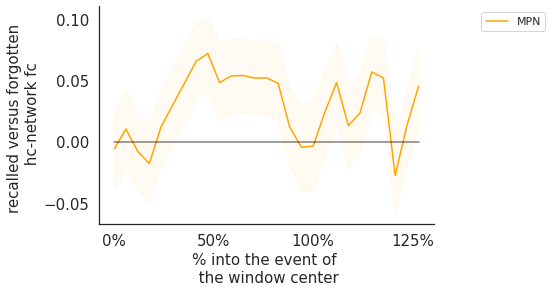

In [231]:
sns.set_theme('notebook')
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 45}

matplotlib.rc('font', **font)
plt.plot(np.transpose(fc_estimate_all[1]), color = 'orange')

zero_line=[]
for x in range(27):
    zero_line.append(0) 
    
plt.plot(zero_line, color = 'black', alpha = .5)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('recalled versus forgotten \n hc-network fc',fontsize=15)
plt.legend(['MPN'], bbox_to_anchor=(.85,.5, .5, .5))
plt.tick_params(axis='both', which='major', labelsize=15)

x_value=[]
for x in range(27):
    x_value.append(x) 

#plt.fill_between(x_value, np.array(fc_estimate_all)-stdev_estimate_all, np.array(fc_estimate_all)+stdev_estimate_all,alpha=0.25)
#plt.fill_between(x_value, np.array(fc_estimate_all[0])-stdev_estimate_all[0], np.array(fc_estimate_all[0])+stdev_estimate_all[0],alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_all[1])-stdev_estimate_all[1], np.array(fc_estimate_all[1])+stdev_estimate_all[1],alpha=0.05, color = 'orange')
#plt.fill_between(x_value, np.array(fc_estimate_all[2])-stdev_estimate_all[2], np.array(fc_estimate_all[2])+stdev_estimate_all[2],alpha=0.05, color = 'green')
#plt.fill_between(x_value, np.array(fc_estimate_all[3])-stdev_estimate_all[3], np.array(fc_estimate_all[3])+stdev_estimate_all[3],alpha=0.05)


locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

plt.savefig(analysis_dir+'hc-mpn-fc-sliding-window-recall.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [74]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
plt.plot(x_value,fc_estimate_pmn)
plt.plot(x_value,fc_estimate_mpn,alpha=.1)
plt.plot(x_value,fc_estimate_mtn,alpha=.1)
plt.plot(x_value,fc_estimate_atn,alpha=.1)
#plt.errorbar(x_value,fc_estimate_pmn,yerr=stdev_estimate_pmn)
#plt.errorbar(x_value,fc_estimate_mpn,yerr=stdev_estimate_mpn, alpha = .2)
#plt.errorbar(x_value,fc_estimate_mtn,yerr=stdev_estimate_mtn, alpha = .2)
#plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn, alpha = .2)
plt.plot(zero_line, color = 'black', alpha = .5)
plt.xlabel('% into the event of \n the window center')
plt.ylabel('recalled versus forgotten \n hc-network fc')
plt.legend(['PMN', 'MPN','MTN','ATN'], bbox_to_anchor=(.85,.5, .5, .5))

plt.fill_between(x_value, np.array(fc_estimate_pmn)-stdev_estimate_pmn, np.array(fc_estimate_pmn)+stdev_estimate_pmn,alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_mpn)-stdev_estimate_mpn, np.array(fc_estimate_mpn)+stdev_estimate_mpn,alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_mtn)-stdev_estimate_mtn, np.array(fc_estimate_mtn)+stdev_estimate_mtn,alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_atn)-stdev_estimate_atn, np.array(fc_estimate_atn)+stdev_estimate_atn,alpha=0.05)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


NameError: name 'fc_estimate_pmn' is not defined

In [164]:
window = 17
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='PMN']

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model = smf.mixedlm('fc~event_recalled+net1_label', model_data3,
                    groups = 'subject', missing='drop',re_formula = 'event_recalled')
mdf = model.fit()


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [694]:
print(mdf.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        fc      
No. Observations:          1344           Method:                    REML    
No. Groups:                24             Scale:                     0.0451  
Min. group size:           56             Log-Likelihood:            133.3733
Max. group size:           56             Converged:                 Yes     
Mean group size:           56.0                                              
-----------------------------------------------------------------------------
                                    Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                            0.051    0.023 2.270 0.023  0.007  0.096
event_recalled[T.1.0]                0.044    0.020 2.154 0.031  0.004  0.083
net1_label[T.postHC]                 0.021    0.012 1.785 0.074 -0.002  0.043
subjec

## details

In [ ]:
fc_estimate_all = []
stdev_estimate_all = []

for net in range(np.size(DMN_nets)):
    
    fc_estimate = []
    stdev_estimate = []
    for window in range(27):


        sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
        model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]
        model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[net]]

        model_data3 = pd.concat([model_data1, model_data2])
        model_data_sub_mean =model_data3.groupby('subject').mean()

        fc_mc = []
        for i in range(np.shape(model_data3)[0]):
            fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


        model_data3['fc_mc'] =fc_mc
        model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

        model_data3['boundary_diff_hc'] =boundary_diff_hc
        model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
        model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
        model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
        model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])
        model_data3 = model_data3[model_data3['event_length']>39]

        model = smf.mixedlm('fc~event_recalled', model_data3,
                            groups = 'subject', missing='drop')
        mdf = model.fit(method = 'lbfgs')

        fc_estimate.append(mdf.params[1])
        stdev_estimate.append(mdf.bse[1])
    fc_estimate_all.append(fc_estimate)
    stdev_estimate_all.append(stdev_estimate)

In [447]:
DMN_nets

['PMN', 'MPN', 'MTN', 'ATN']

In [536]:
np.shape(sliding_window_encoding_fc_recall)

(24192, 14)

In [544]:
np.sum(sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='antHC'][sliding_window_encoding_fc_recall['movie']=='bluestreets'][sliding_window_encoding_fc_recall['subject']=='sub-000']['event_length']<43)

2

# Total event details LOG

In [96]:
fc_estimate = []
stdev_estimate = []
pvalues = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(window)+'.csv')

    sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

    model_data3['total_details_log'] = np.log(model_data3['total_details'])
    
    model_data3 = model_data3[model_data3['total_details_log']>-1][model_data3['delay']==2]

    model = smf.mixedlm('total_details_log~fc_mc', model_data3,
                                groups = 'subject', missing='drop',re_formula = 'fc_mc')
    mdf = model.fit(method = 'lbfgs')
    fc_estimate.append(mdf.params[1])
    stdev_estimate.append(mdf.bse[1])
    pvalues.append(mdf.pvalues[1])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimizat

In [54]:
fc_estimate[11]

0.29406582534530773

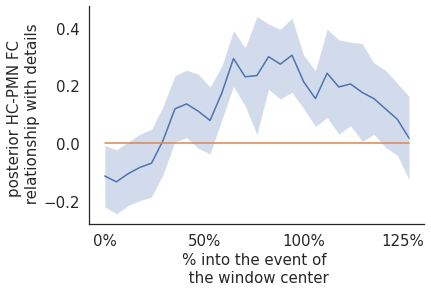

In [98]:
plt.plot(fc_estimate)
plt.plot(zero_line)
plt.fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('posterior HC-PMN FC \n relationship with details',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

plt.savefig(analysis_dir+'hc-pmn-fc-sliding-window-details.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

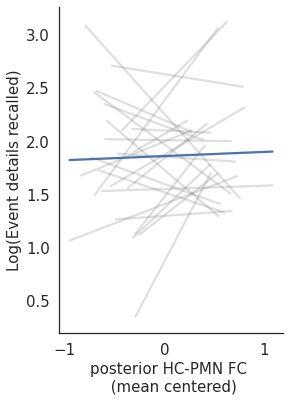

In [201]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(0)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])


fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details']>0],
              line_kws={'alpha': .25},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details']>0],)



plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

sns.despine()

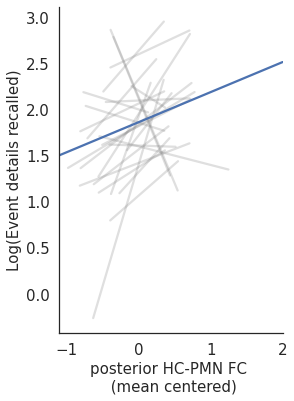

In [191]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(11)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])


fig, ax = plt.subplots(figsize=(4, 6))
plt.xlim([-1.1, 2])
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
              line_kws={'alpha': .25},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',truncate = False,
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)

plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

sns.despine()


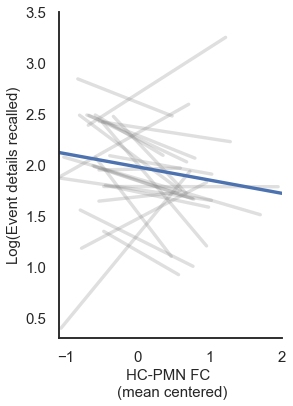

In [219]:
# immediate recall
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(17)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])

sns.set_theme('talk')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4, 6))
plt.xlim([-1.1, 2])
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==0][model_data3['subject']==subject_list[sub]][model_data3['total_details_log']>-1],
              line_kws={'alpha': .25},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',truncate = False,
               data = model_data3[model_data3['delay']==0][model_data3['total_details_log']>-1],)

plt.xlabel('HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim([0.3,3.5])

sns.despine()
plt.savefig(analysis_dir+'hc-pmn-offset_details_imm.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

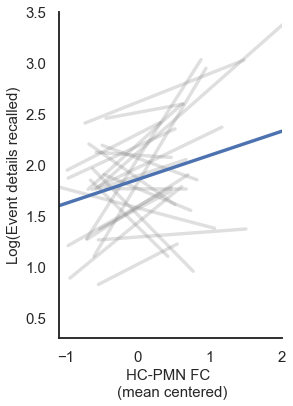

In [222]:
# 2-day delay
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(17)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])


sns.set_theme('talk')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4, 6))
plt.xlim([-1.1, 2])
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['total_details_log']>-1],
              line_kws={'alpha': .25},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',truncate = False,
               data = model_data3[model_data3['delay']==2][model_data3['total_details_log']>-1],)

plt.xlabel('HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim([0.3,3.5])

sns.despine()
plt.savefig(analysis_dir+'hc-pmn-offset_details_2day.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [ ]:
ax2 = plt.subplots(1,2, figsize=(8, 6))

ax2 = plt.plot(fc_estimate)
ax2 = plt.plot(zero_line)
ax2 = plt.fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('posterior HC-PMN FC \n relationship with details',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()


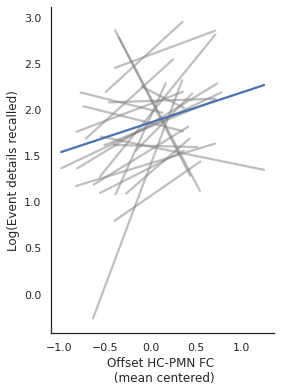

In [197]:
fig, ax = plt.subplots(figsize=(4, 6))

for sub in range(num_subs):
    ax = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
                    data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
                    line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
ax = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
                    data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)
plt.xlabel('Offset HC-PMN FC \n (mean centered)')
plt.ylabel('Log(Event details recalled)')
plt.tick_params(axis='both', which='major')
sns.despine()

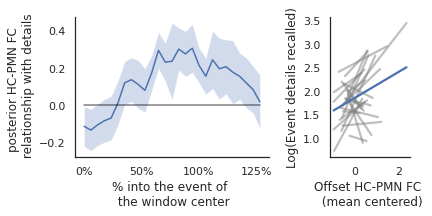

In [187]:
  
# Placing the plots in the plane
plot1 = plt.subplot2grid((3, 12), (0, 0), colspan=7,rowspan = 2)
plt.xlabel('% into the event of \n the window center')
plt.ylabel('posterior HC-PMN FC \n relationship with details')
plt.tick_params(axis='both', which='major')
locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
plot2 = plt.subplot2grid((3, 12), (0, 9), rowspan = 2,colspan = 4)

  

for sub in range(num_subs):
    ax[1] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
ax[1] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)
plt.xlabel('Offset HC-PMN FC \n (mean centered)')
plt.ylabel('Log(Event details recalled)')
plt.tick_params(axis='both', which='major')
  
# Plot for exponent
plot1.plot(fc_estimate)
plot1.fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)
plot1.plot(zero_line,color = 'black', alpha = .5)

plt.tight_layout()
sns.despine()


plt.savefig(analysis_dir+'hc-pmn-fc-offset-details.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

Text(0.5, 1.0, 'Cosine Function')

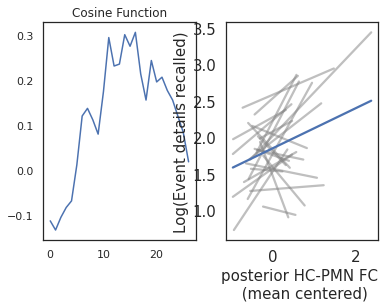

In [146]:
# Initialise the subplot function using number of rows and columns
fig, ax = plt.subplot2grid(1, 2)

for sub in range(num_subs):
    ax[1] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
ax[1] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)
plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

  

# For Cosine Function
ax[0].plot(fc_estimate)
ax[0].set_title("Cosine Function")


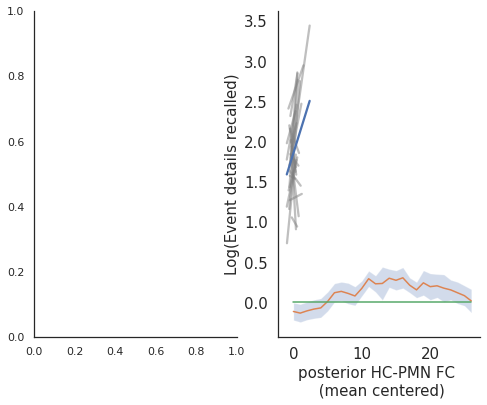

In [129]:

#plt.savefig(analysis_dir+'hc-pmn-fc-sliding-window-details.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(17)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])

fig, ax = plt.subplots(1, 2, figsize=(8, 6),sharex=False, sharey=False)
#fig, ax = plt.subplots(1,1, figsize=(4, 6))
for sub in range(num_subs):
    ax[0] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
ax[0] = sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)
plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

sns.despine()

ax[0].plot(fc_estimate)
ax[0].plot(zero_line)
ax[0].fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)

##plt.xlabel('% into the event of \n the window center',fontsize=15)
#plt.ylabel('posterior HC-PMN FC \n relationship with details',fontsize=15)
#plt.tick_params(axis='both', which='major', labelsize=15)

#locs, labels = plt.xticks()
#plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
#sns.despine()


#plt.savefig(analysis_dir+'hc-pmn-fc-offset-details.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

In [123]:
ax[1]

<AxesSubplot:xlabel='posterior HC-PMN FC \n (mean centered)', ylabel='Log(Event details recalled)'>

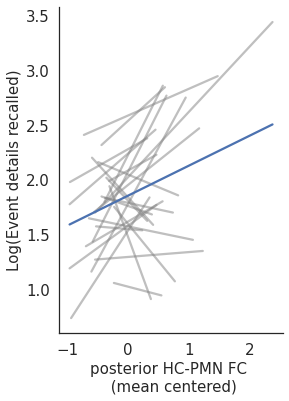

In [100]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(17)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])


fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>-1],)
plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

sns.despine()

plt.savefig(analysis_dir+'hc-pmn-fc-offset-details.tiff', format='tiff',dpi=300,bbox_inches = 'tight')

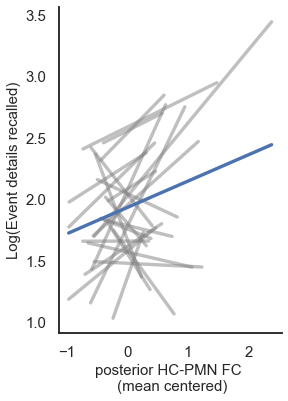

In [42]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_'+str(17)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['total_details_log'] = np.log(model_data3['total_details'])


fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['delay']==2][model_data3['subject']==subject_list[sub]][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>0],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['delay']==2][model_data3['net1_label']=='postHC'][model_data3['total_details_log']>0],)

plt.xlabel('posterior HC-PMN FC \n (mean centered)',fontsize=15)
plt.ylabel('Log(Event details recalled)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

sns.despine()

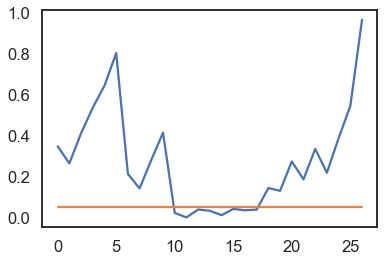

In [40]:
plt.plot(pvalues)
alpha_line=[]
for x in range(27):
    alpha_line.append(0.05)
plt.plot(alpha_line)

# Central details

In [943]:
fc_estimate = []
stdev_estimate = []
pvalues = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')

    sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

    model_data3['peri_d_log'] = np.log(model_data3['peri_d'])
    model_data3['central_d_log'] = np.log(model_data3['central_d'])
    model_data3 = model_data3[model_data3['central_d_log']>0]
    
    model = smf.mixedlm('central_d~delay+fc_mc:delay+fc_mc+fc_mc:net1_label+fc_mc:net1_label:delay+ fc_mc + boundary_diff_pmn*boundary_diff_hc:net1_label*delay+ event_length+ fc_mc:net1_label+fc_mc:net1_label:delay',
                        model_data3,
                                groups = 'subject', missing='drop', re_formula = 'fc_mc')
    mdf = model.fit(method = 'lbfgs')
    fc_estimate.append(mdf.params[4])
    stdev_estimate.append(mdf.bse[4])
    pvalues.append(mdf.pvalues[4])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


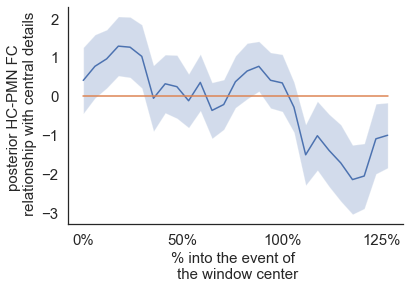

In [944]:
plt.plot(fc_estimate)
plt.plot(zero_line)
plt.fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)




plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('posterior HC-PMN FC \n relationship with central details',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

<AxesSubplot:xlabel='fc_mc', ylabel='central_d'>

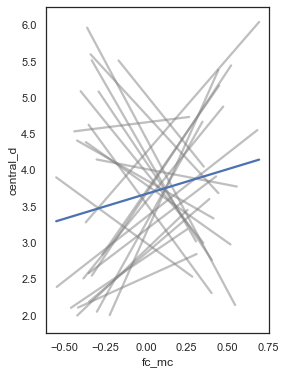

In [947]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(0)+'.csv')

sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc
model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model_data3['peri_d_log'] = np.log(model_data3['peri_d'])
model_data3['central_d_log'] = np.log(model_data3['central_d'])
model_data3 = model_data3[model_data3['central_d_log']>0]

fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'central_d',ci = 0,
               data = model_data3[model_data3['total_details']>0][model_data3['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
sns.regplot(x = 'fc_mc', y = 'central_d',ci = 0,scatter = False,units='subject',
               data = model_data3[model_data3['total_details']>0])


<AxesSubplot:xlabel='fc_mc', ylabel='central_d'>

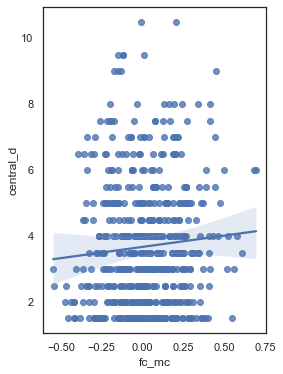

In [951]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.regplot(x = 'fc_mc', y = 'central_d',ci = 95,scatter = True,units='subject',
               data = model_data3[model_data3['total_details']>0])

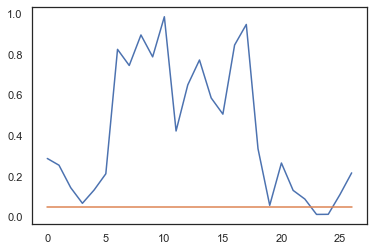

In [527]:
plt.plot(pvalues)
alpha_line=[]
for x in range(27):
    alpha_line.append(0.05)
plt.plot(alpha_line)

# Peripheral Details

In [941]:
fc_estimate = []
stdev_estimate = []
pvalues = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')

    sliding_window_encoding_fc_recall['total_details']=sliding_window_encoding_fc_recall['peri_d']+sliding_window_encoding_fc_recall['central_d']

    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']==DMN_nets[0]]

    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    model_data3['event_recalled'] = model_data3['event_recalled'].astype('category')

    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

    model_data3['peri_d_log'] = np.log(model_data3['peri_d'])
    
    model_data3 = model_data3[model_data3['peri_d_log']>-1][model_data3['net1_label']=='postHC'][model_data3['delay']==2]

    model = smf.mixedlm('peri_d_log~fc_mc+event_length', model_data3,
                                groups = 'subject', missing='drop',re_formula = 'fc_mc')
    mdf = model.fit(method = 'lbfgs')
    fc_estimate.append(mdf.params[1])
    stdev_estimate.append(mdf.bse[1])
    pvalues.append(mdf.pvalues[1])


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 9.095229
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

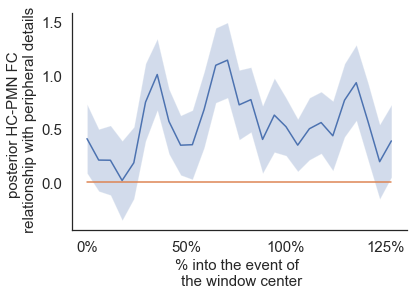

In [942]:
plt.plot(fc_estimate)
plt.plot(zero_line)
plt.fill_between(x_value, np.array(fc_estimate)-stdev_estimate, np.array(fc_estimate)+stdev_estimate,alpha=0.25)

plt.xlabel('% into the event of \n the window center',fontsize=15)
plt.ylabel('posterior HC-PMN FC \n relationship with peripheral details',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])
sns.despine()

In [285]:
sliding_window_encoding_fc_recall_details = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['total_details']>0]

In [286]:
sliding_window_encoding_fc_recall_details['peri_d_log'] = np.log(sliding_window_encoding_fc_recall_details['peri_d'])

In [170]:
boundary_and_nonboundary_encoding_fc_details = pd.read_csv('/Users/barnettlab/Documents/cartoon_recall/fmri_data/boundary_and_nonboundary_encoding_fc_details_neuron_filter.csv')

In [ ]:
boundary_and_nonboundary_encoding_fc_details_mean

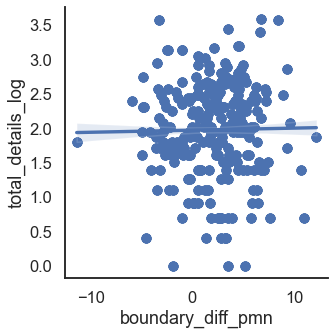

In [175]:
sns.lmplot(x = 'boundary_diff_pmn', y ='total_details_log',  data =  boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['delay']==0])

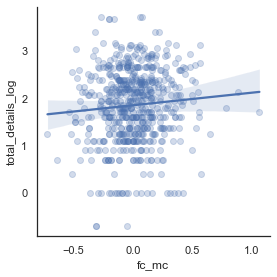

In [257]:
sns.lmplot(x = 'fc_mc', y ='total_details_log',units = 'subject',  data =  boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['delay']==2][boundary_and_nonboundary_encoding_fc_details['net1_label']=='postHC'],scatter_kws ={'alpha':0.25})

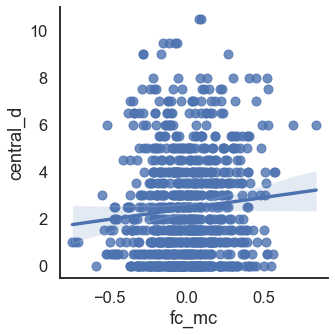

In [221]:
sns.lmplot(x = 'fc_mc', y ='central_d',units = 'subject',  data =  boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['window']=='event_onset'])

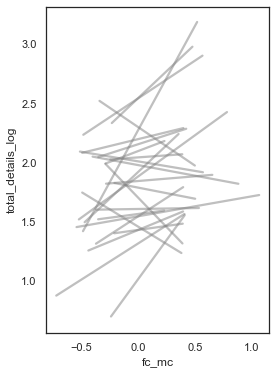

In [281]:
temp = boundary_and_nonboundary_encoding_fc_details.groupby(by=['subject','delay','window','events','movie'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['delay']==2][boundary_and_nonboundary_encoding_fc_details['subject']==subject_list[sub]][boundary_and_nonboundary_encoding_fc_details['net1_label']=='postHC'][boundary_and_nonboundary_encoding_fc_details['peri_d']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
#plt.plot([-.5,1],[1.4382-(0.3919/2),1.4382+0.3919],color='red',linewidth=3)



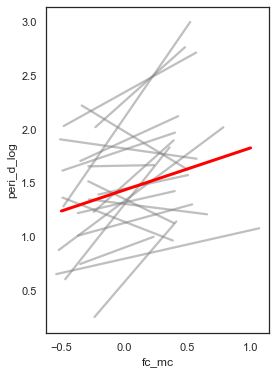

In [280]:
temp = boundary_and_nonboundary_encoding_fc_details.groupby(by=['subject','delay','window','events','movie'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'peri_d_log',ci = 0,
               data = boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['delay']==2][boundary_and_nonboundary_encoding_fc_details['subject']==subject_list[sub]][boundary_and_nonboundary_encoding_fc_details['net1_label']=='postHC'][boundary_and_nonboundary_encoding_fc_details['peri_d']>-1],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)
plt.plot([-.5,1],[1.4382-(0.3919/2),1.4382+0.3919],color='red',linewidth=3)




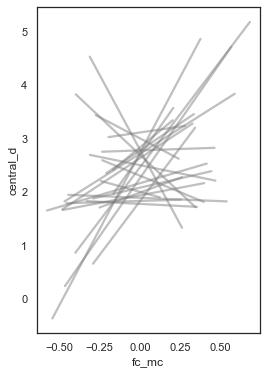

In [425]:
temp = boundary_and_nonboundary_encoding_fc_details.groupby(by=['subject','delay','window','events','movie'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'central_d',ci = 0,
               data = temp[temp['window']=='event_onset'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter = False,color='grey', truncate = True)

In [ ]:
# immediate recall

temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='offset'][temp['delay']=='0'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1],[1.744,2.088],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

In [349]:
fc_estimate_mpn = fc_estimate
stdev_estimate_mpn = stdev_estimate

In [401]:
x_value=[]
for x in range(27):
    x_value.append(x) 

In [411]:
zero_line=[]
for x in range(27):
    zero_line.append(0) 

In [403]:
np.shape(x_value)

(27,)

In [375]:
import matplotlib

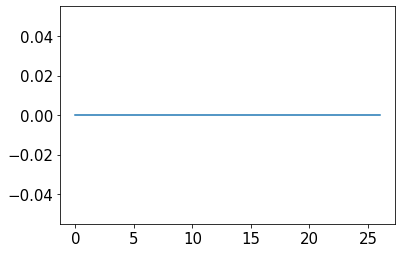

In [412]:
plt.plot(zero_line )

([<matplotlib.axis.XTick at 0x7fab81c2a280>,
 [Text(0.0, 0, '0%'),
  Text(8.5, 0, '50%'),
  Text(17.0, 0, '100%'),
  Text(25.5, 0, '125%')])

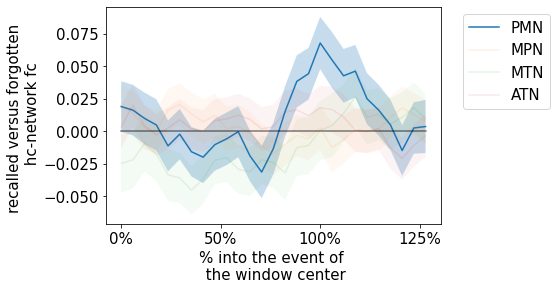

In [426]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
plt.plot(x_value,fc_estimate_pmn)
plt.plot(x_value,fc_estimate_mpn,alpha=.1)
plt.plot(x_value,fc_estimate_mtn,alpha=.1)
plt.plot(x_value,fc_estimate_atn,alpha=.1)
#plt.errorbar(x_value,fc_estimate_pmn,yerr=stdev_estimate_pmn)
#plt.errorbar(x_value,fc_estimate_mpn,yerr=stdev_estimate_mpn, alpha = .2)
#plt.errorbar(x_value,fc_estimate_mtn,yerr=stdev_estimate_mtn, alpha = .2)
#plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn, alpha = .2)
plt.plot(zero_line, color = 'black', alpha = .5)
plt.xlabel('% into the event of \n the window center')
plt.ylabel('recalled versus forgotten \n hc-network fc')
plt.legend(['PMN', 'MPN','MTN','ATN'], bbox_to_anchor=(.85,.5, .5, .5))

plt.fill_between(x_value, np.array(fc_estimate_pmn)-stdev_estimate_pmn, np.array(fc_estimate_pmn)+stdev_estimate_pmn,alpha=0.25)
plt.fill_between(x_value, np.array(fc_estimate_mpn)-stdev_estimate_mpn, np.array(fc_estimate_mpn)+stdev_estimate_mpn,alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_mtn)-stdev_estimate_mtn, np.array(fc_estimate_mtn)+stdev_estimate_mtn,alpha=0.05)
plt.fill_between(x_value, np.array(fc_estimate_atn)-stdev_estimate_atn, np.array(fc_estimate_atn)+stdev_estimate_atn,alpha=0.05)

locs, labels = plt.xticks()
plt.xticks([0, 8.5, 17,25.5], ['0%', '50%', '100%', '125%'])


In [419]:
fc_estimate_pmn

[0.019158743346024912,
 0.01640209328501068,
 0.010031947641407003,
 0.005058259757181746,
 -0.011105072466972604,
 -0.0020549680853462096,
 -0.015582072360477836,
 -0.01977298218760494,
 -0.010133331209018756,
 -0.005700670829654111,
 -0.0001877497041363648,
 -0.01877295423812886,
 -0.031235998144080002,
 -0.013132660989055788,
 0.015362006902633934,
 0.03851423415306071,
 0.044426063567282514,
 0.06803095319720913,
 0.055125000926395086,
 0.04280548278864833,
 0.04640317951793664,
 0.025179867234199,
 0.016377294583029563,
 0.005065738687877175,
 -0.0146261391828465,
 0.002678035753965596,
 0.003803830364996923]

In [ ]:
#plt.plot(fc_estimate)
plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn)

<ErrorbarContainer object of 3 artists>

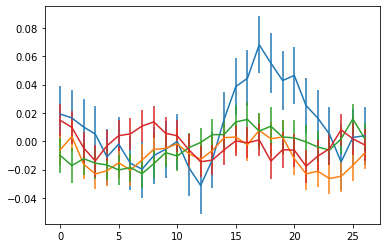

In [336]:
#plt.plot(fc_estimate)
plt.errorbar(x_value,fc_estimate_pmn,yerr=stdev_estimate_pmn)
plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn)
plt.errorbar(x_value,fc_estimate_mtn,yerr=stdev_estimate_mtn)
plt.errorbar(x_value,fc_estimate_mpn,yerr=stdev_estimate_mpn)

<ErrorbarContainer object of 3 artists>

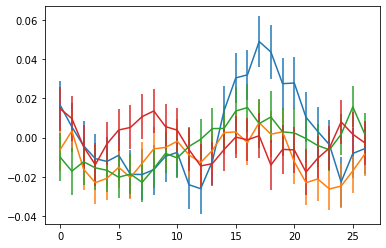

In [292]:
#plt.plot(fc_estimate)
plt.errorbar(x_value,fc_estimate_pmn,yerr=stdev_estimate_pmn)
plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn)
plt.errorbar(x_value,fc_estimate_mtn,yerr=stdev_estimate_mtn)
plt.errorbar(x_value,fc_estimate_mpn,yerr=stdev_estimate_mpn)

<ErrorbarContainer object of 3 artists>

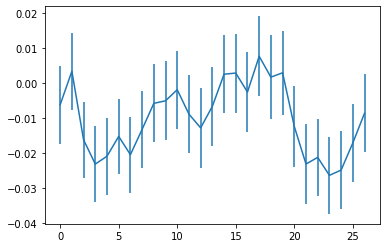

In [288]:
#plt.plot(fc_estimate)
plt.errorbar(x_value,fc_estimate_atn,yerr=stdev_estimate_atn)

<ErrorbarContainer object of 3 artists>

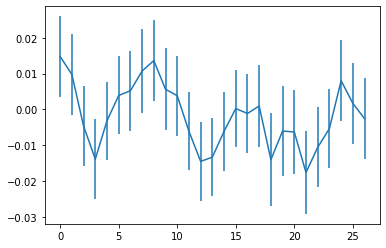

In [291]:
#plt.plot(fc_estimate)
plt.errorbar(x_value,fc_estimate_mpn,yerr=stdev_estimate_mpn)

In [258]:
fc_estimate

[0.016576824728717226,
 0.005459797837156823,
 -0.0041896159448914375,
 -0.010763994133912805,
 -0.012204591991526586,
 -0.009053543125833738,
 -0.018770557310990237,
 -0.01889125932002579,
 -0.016382811442479765,
 -0.009552272616125235,
 -0.007601322554757143,
 -0.024132013821822625,
 -0.026136460931123446,
 -0.012218574614032291,
 0.013723132404372259,
 0.030520778996538805,
 0.032106736829578944,
 0.04913498005071636]

In [495]:
fc_estimate = []
stdev_estimate = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN']
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN']
    
    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    
    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

    model = smf.mixedlm('fc~event_recalled', model_data3[model_data3['delay']==2][model_data3['net1_label']=='antHC'],groups = 'subject', missing='drop')
    mdf = model.fit()

    fc_estimate.append(mdf.params[1])
    stdev_estimate.append(mdf.bse[1])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

In [491]:
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   fc      
No. Observations:    624       Method:               REML    
No. Groups:          24        Scale:                0.0302  
Min. group size:     26        Log-Likelihood:       175.4475
Max. group size:     26        Converged:            Yes     
Mean group size:     26.0                                    
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.129    0.021 6.177 0.000  0.088  0.170
net1_label[T.postHC] 0.025    0.014 1.785 0.074 -0.002  0.052
event_recalled       0.011    0.015 0.707 0.480 -0.019  0.040
subject Var          0.006    0.013                          



In [492]:
fc_estimate

[0.02707515174528526,
 0.023668449625632294,
 -0.0036700046244324833,
 -0.019346686214974262,
 -0.006307877012474348,
 0.008933199906814957,
 0.008521226850830711,
 0.011360492968281238,
 0.026579807298938666,
 0.01759312133888644,
 0.017922147873085926,
 0.017576928969086296,
 0.011274030990927462,
 0.004255648961908132,
 0.01162931713803886,
 0.012306418273139217,
 -0.0016253673351701754,
 -0.0074085086853539475,
 -0.026665656456190314,
 -0.01903704460036812,
 -0.018533762141722185,
 -0.02797587284116405,
 -0.012650570245455354,
 0.002498887266634908,
 0.022377833127770565,
 0.011179760347828457,
 0.010502858894841727]

In [493]:
fc_estimate_mpn_hip = fc_estimate
stdev_estimate_mpn_hip= stdev_estimate

In [466]:
fc_estimate_mpn_min = fc_estimate
stdev_estimate_mpn_min= stdev_estimate

<AxesSubplot:xlabel='event_recalled', ylabel='fc'>

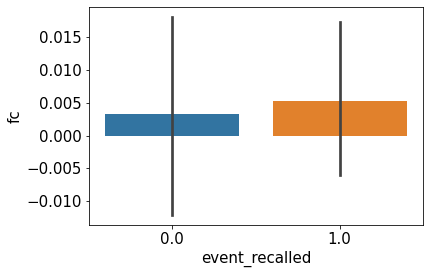

In [480]:
sns.barplot( x = 'event_recalled', y = 'fc', data =model_data1)

In [463]:
fc_estimate_pmn_min = fc_estimate
stdev_estimate_pmn_min= stdev_estimate

In [460]:
mdf.params

Intercept               0.140134
net1_label[T.postHC]    0.018485
event_recalled         -0.002576
subject Var             0.084695
dtype: float64

<ErrorbarContainer object of 3 artists>

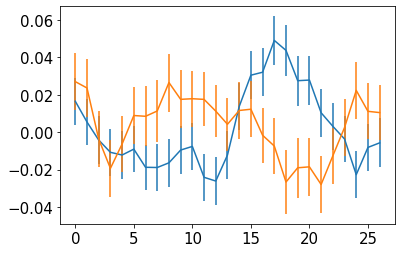

In [494]:
plt.errorbar(x_value,fc_estimate_pmn_min,yerr=stdev_estimate_pmn_min)
plt.errorbar(x_value,fc_estimate_mpn_hip,yerr=stdev_estimate_mpn_hip)

<ErrorbarContainer object of 3 artists>

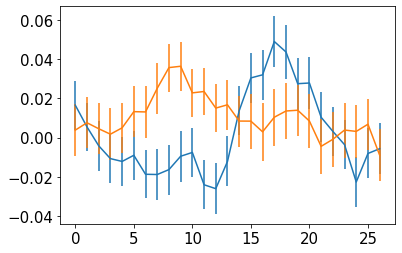

In [489]:
plt.errorbar(x_value,fc_estimate_pmn_min,yerr=stdev_estimate_pmn_min)
plt.errorbar(x_value,fc_estimate_mpn_mtn,yerr=stdev_estimate_mpn_mtn)

<ErrorbarContainer object of 3 artists>

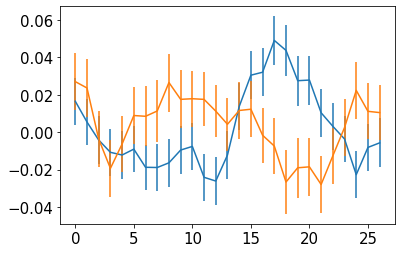

In [467]:
plt.errorbar(x_value,fc_estimate_pmn_min,yerr=stdev_estimate_pmn_min)
plt.errorbar(x_value,fc_estimate_mpn_min,yerr=stdev_estimate_mpn_min)

<ErrorbarContainer object of 3 artists>

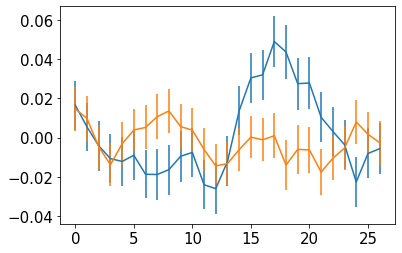

In [464]:
plt.errorbar(x_value,fc_estimate_pmn_min,yerr=stdev_estimate_pmn_min)
plt.errorbar(x_value,fc_estimate_mpn_min,yerr=stdev_estimate_mpn_min)

<ErrorbarContainer object of 3 artists>

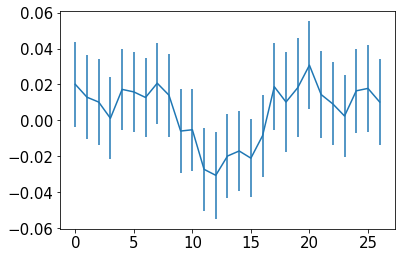

In [451]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

In [648]:
fc_estimate = []
stdev_estimate = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='ATN']
    model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='ATN']
    
    model_data3 = pd.concat([model_data1, model_data2])
    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc
    
    model_data3['boundary_diff_hc'] =boundary_diff_hc
    model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
    model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
    model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
    model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

    model_data3['total_details']=model_data3['central_d']+model_data3['peri_d']
    model_data3['total_details_log'] =np.log(model_data3['total_details'])
    model_data3 = model_data3[model_data3['total_details']>0]
    model_data3['peri_d_log'] =np.log(model_data3['peri_d'])

    model_data_sub_mean =model_data3.groupby('subject').mean()

    fc_mc = []
    for i in range(np.shape(model_data3)[0]):
        fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


    model_data3['fc_mc'] =fc_mc



    model = smf.mixedlm('central_d~fc_mc+fc_mc+fc_mc+fc_mc:net1_label+fc_mc:net1_label+fc_mc:net1_label+event_length+movie',
                        model_data3[model_data3['delay']==0],groups = 'subject', missing='drop')
    mdf = model.fit(method=['bfgs', 'bfgs', 'cg'])

    fc_estimate.append(mdf.params[2])
    stdev_estimate.append(mdf.bse[2])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with bfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 6.154648
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying M

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 5.662

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with bfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

In [624]:
np.nanstd(model_data1['fc'].values)

0.2017608453195911

In [670]:
fc_value = []
fc_value_recalled =[]
fc_value_forgotten = []
for window in range(27):
    sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(window)+'.csv')
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN']
    fc_value.append(np.nanmean(model_data1['fc'].values))
    
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN'][sliding_window_encoding_fc_recall['event_recalled']==1]
    fc_value_recalled.append(np.nanmean(model_data1['fc'].values))
    model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN'][sliding_window_encoding_fc_recall['event_recalled']==0]
    fc_value_forgotten.append(np.nanmean(model_data1['fc'].values))

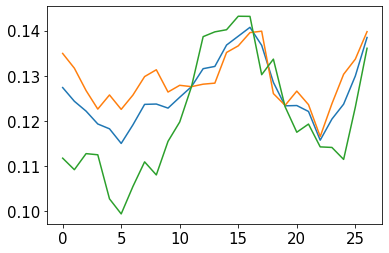

In [671]:
plt.plot(fc_value)
plt.plot(fc_value_recalled)
plt.plot(fc_value_forgotten)

In [ ]:
sns.lineplot( x = 'fc', y = )

<ErrorbarContainer object of 3 artists>

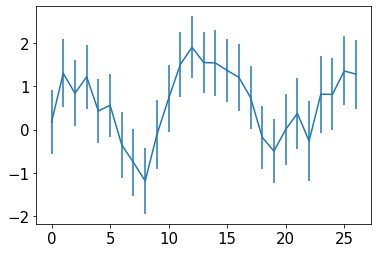

In [649]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

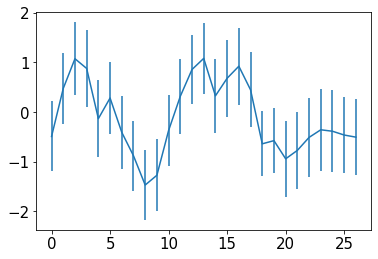

In [620]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

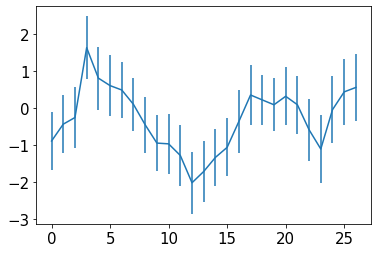

In [618]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

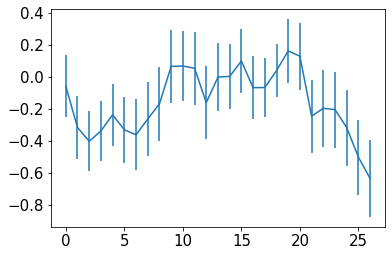

In [612]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

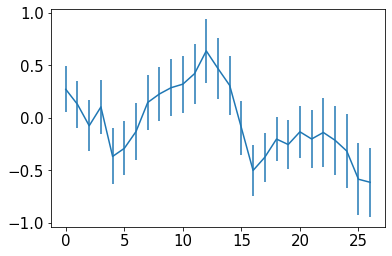

In [609]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

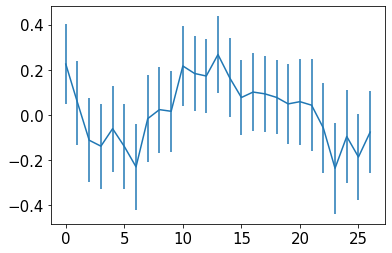

In [605]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

<ErrorbarContainer object of 3 artists>

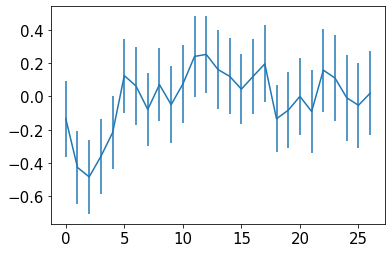

In [607]:
plt.errorbar(x_value,fc_estimate,yerr=stdev_estimate)

In [591]:
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   total_details_log
No. Observations:   356       Method:               REML             
No. Groups:         24        Scale:                0.4730           
Min. group size:    8         Log-Likelihood:       -396.1049        
Max. group size:    24        Converged:            Yes              
Mean group size:    14.8                                             
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.688    0.167 10.111 0.000  1.361  2.015
movie[T.bluestreets]        0.322    0.158  2.034 0.042  0.012  0.632
fc_mc                       0.020    0.252  0.078 0.938 -0.474  0.513
fc_mc:net1_label[T.postHC]  0.210    0.360  0.583 0.560 -0.496  0.915
event_length               -0.001   

In [610]:
mdf.params

Intercept                     1.686000
movie[T.bluestreets]          0.316491
fc_mc                        -0.615689
fc_mc:net1_label[T.postHC]    1.003941
event_length                 -0.000573
subject Var                   0.258826
dtype: float64

In [580]:
model_data3['delay'].unique()

array([0, 2])

In [588]:

model_data3['total_details']=model_data3['central_d']+model_data3['peri_d']
model_data3['total_details_log'] =np.log(model_data3['total_details'])
model_data3 = model_data3[model_data3['total_details']>0]
model_data3['peri_d_log'] =np.log(model_data3['peri_d'])

model_data_sub_mean =model_data3.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc



model = smf.mixedlm('total_details_log~fc_mc*delay+fc_mc:delay+fc_mc+fc_mc:net1_label+fc_mc:net1_label:delay+fc_mc:net1_label:delay+event_length+movie',
                    model_data3[model_data3['delay']==2],groups = 'subject', missing='drop')
mdf = model.fit(method=['bfgs', 'bfgs', 'cg'])
print(mdf.summary())

LinAlgError: Singular matrix

In [587]:
mdf.params[2]

-0.09283930553155431

In [448]:
sliding_window_encoding_fc_recall = pd.read_csv(analysis_dir+'sliding_window_encoding_fc_recall_pd_neuron_filter_'+str(8)+'.csv')
model_data1 =sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='postHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN']
model_data2 = sliding_window_encoding_fc_recall[sliding_window_encoding_fc_recall['net1_label']=='antHC'][sliding_window_encoding_fc_recall['net2_label']=='MPN']

model_data3 = pd.concat([model_data1, model_data2])
model_data_sub_mean =model_data3.groupby('subject').mean()

fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc

model_data3['boundary_diff_hc'] =boundary_diff_hc
model_data3['boundary_diff_pmn'] =np.concatenate([boundary_diff_pmn,boundary_diff_pmn])
model_data3['boundary_diff_mtn'] =np.concatenate([boundary_diff_mtn,boundary_diff_mtn])
model_data3['boundary_diff_mpn'] =np.concatenate([boundary_diff_mpn,boundary_diff_mpn])
model_data3['boundary_diff_atn'] =np.concatenate([boundary_diff_atn,boundary_diff_atn])

model = smf.mixedlm('fc~event_recalled', model_data3[model_data3['delay']==2],groups = 'subject', missing='drop')
mdf = model.fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [449]:
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: fc      
No. Observations:  672     Method:             REML    
No. Groups:        24      Scale:              0.0357  
Min. group size:   28      Log-Likelihood:     140.6373
Max. group size:   28      Converged:          Yes     
Mean group size:   28.0                                
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.123    0.019 6.338 0.000  0.085  0.161
event_recalled 0.027    0.016 1.711 0.087 -0.004  0.057
subject Var    0.006    0.011                          



In [235]:
mdf.params[2]

0.04913498005071636

In [237]:
mdf.bse[2]

0.012933463726556823

In [224]:
810 -start_window

10

In [225]:
end_window - 810

10

In [217]:
glasser_nodes[glasser_nodes['community_sublabels']==15]

,id,community,size,community_sublabels,color,Unnamed: 5,Unnamed: 6
359,l_post,15,2,15,#929292,NaN,NaN
361,r_post,15,2,15,#929292,NaN,NaN


In [207]:
end

731

In [164]:
event_length_tracker

89

In [167]:
(810-720)/num_windows

5.294117647058823

In [168]:
window

16

In [156]:
bluestreets_boundaries

array([[  5.        ,  66.47540984, 127.95081967, 190.24590164,
        256.63934426, 317.29508197, 368.93442623, 436.14754098,
        478.7704918 , 550.08196721, 624.67213115, 683.68852459,
        704.18032787, 720.57377049, 809.91803279]])

In [229]:
model_data1 =sliding_window_encoding_fc_recall_pd[sliding_window_encoding_fc_recall_pd['net1_label']=='postHC'][sliding_window_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = sliding_window_encoding_fc_recall_pd[sliding_window_encoding_fc_recall_pd['net1_label']=='antHC'][sliding_window_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])

<AxesSubplot:xlabel='event_recalled', ylabel='fc'>

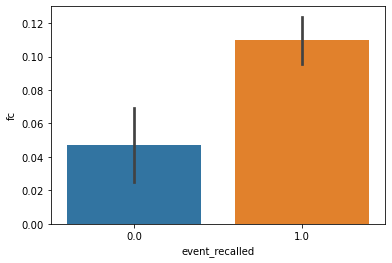

In [230]:
sns.barplot( x = 'event_recalled', y = 'fc', data = model_data3)

In [223]:
model_data3.head(14)

,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d
32,sub-000,barmaid,1,0,-0.023337,postHC,PMN,1,48.0,1.0,6.0,4.0
68,sub-000,barmaid,2,0,0.099598,postHC,PMN,2,32.0,0.0,0.0,0.0
104,sub-000,barmaid,3,0,-0.081461,postHC,PMN,3,51.0,1.0,5.0,3.5
140,sub-000,barmaid,4,0,0.011666,postHC,PMN,4,24.0,1.0,4.5,1.0
176,sub-000,barmaid,5,0,0.084111,postHC,PMN,5,91.0,1.0,2.0,1.0
212,sub-000,barmaid,6,0,0.190983,postHC,PMN,6,41.0,1.0,4.5,0.5
248,sub-000,barmaid,7,0,0.152155,postHC,PMN,7,98.0,1.0,2.0,1.0
284,sub-000,barmaid,8,0,0.108635,postHC,PMN,8,31.0,1.0,3.5,1.5
320,sub-000,barmaid,9,0,0.025052,postHC,PMN,9,36.0,1.0,4.0,0.0
356,sub-000,barmaid,10,0,0.029563,postHC,PMN,10,55.0,0.0,0.0,0.0


In [182]:

model_data_sub_mean =model_data3.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc

model = smf.mixedlm('event_recalled~fc_mc*delay+fc_mc:delay:net1_label+fc_mc:net1_label+event_length+movie', model_data3,groups = 'subject',re_formula='~delay', missing='drop')
mdf = model.fit()
print(mdf.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                     Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       event_recalled
No. Observations:         1344          Method:                   REML          
No. Groups:               24            Scale:                    0.1806        
Min. group size:          56            Log-Likelihood:           -798.2730     
Max. group size:          56            Converged:                No            
Mean group size:          56.0                                                  
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.391    0.043  9.109 0.000  0.307  0.475
delay[T.2]                            -0.159    0.030 -5.309 0.000 -0.218 -0.101
movie[T.bluestreets]                   0.011    0.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 20.542666
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [151]:
sliding_window_encoding_fc_recall_pd

,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,event_recalled,peri_d,central_d
0,sub-000,barmaid,1,0,0.149530,ATN,ATN,1,48.0,1.0,6.0,4.0
1,sub-000,barmaid,1,0,0.106599,ATN,MTN,1,48.0,1.0,6.0,4.0
2,sub-000,barmaid,1,0,0.044967,ATN,PMN,1,48.0,1.0,6.0,4.0
3,sub-000,barmaid,1,0,0.161291,ATN,MPN,1,48.0,1.0,6.0,4.0
4,sub-000,barmaid,1,0,0.118376,ATN,antHC,1,48.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24187,sub-130,bluestreets,14,0,0.012812,postHC,MTN,14,89.0,1.0,5.5,3.5
24188,sub-130,bluestreets,14,0,0.181758,postHC,PMN,14,89.0,1.0,5.5,3.5
24189,sub-130,bluestreets,14,0,0.047495,postHC,MPN,14,89.0,1.0,5.5,3.5
24190,sub-130,bluestreets,14,0,0.093518,postHC,antHC,14,89.0,1.0,5.5,3.5


In [91]:

model_data3['total_details']=model_data3['central_d']+model_data3['peri_d']
model_data3['total_details_log'] =np.log(model_data3['total_details'])

model_data_sub_mean =model_data3.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc

model = smf.mixedlm('fc~event_length', model_data3,groups = 'subject', missing='drop')
mdf = model.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fc      
No. Observations: 1344    Method:             REML    
No. Groups:       24      Scale:              0.0447  
Min. group size:  56      Log-Likelihood:     159.2655
Max. group size:  56      Converged:          Yes     
Mean group size:  56.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.198    0.018 11.241 0.000  0.164  0.233
event_length 0.000    0.000  0.811 0.417 -0.000  0.001
subject Var  0.001    0.003                           



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [57]:
event_boundaries

,subject,event,start,end,movie,start2,end2,delay,run,end_seconds,TR,event_length,recalled,details,detail_logical,mismatch,Unnamed: 16
0,sub-000,1,20.0,65.0,barmaid,NaN,NaN,immediate,1,746,611,45,1,10.0,1.0,2.0,0.986497
1,sub-000,2,NaN,NaN,barmaid,NaN,NaN,immediate,1,746,611,0,0,0.0,0.0,0.0,NaN
2,sub-000,3,65.0,129.0,barmaid,NaN,NaN,immediate,1,746,611,64,1,8.5,1.0,2.0,NaN
3,sub-000,4,133.0,165.0,barmaid,NaN,NaN,immediate,1,746,611,32,1,5.5,1.0,2.0,NaN
4,sub-000,5,165.0,195.0,barmaid,NaN,NaN,immediate,1,746,611,30,1,3.0,1.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,sub-130,10,301.0,320.0,bluestreets,NaN,NaN,immediate,2,383,314,19,1,NaN,NaN,NaN,NaN
668,sub-130,11,262.0,300.0,bluestreets,NaN,NaN,immediate,2,383,314,38,1,NaN,NaN,NaN,NaN
669,sub-130,12,322.0,328.0,bluestreets,NaN,NaN,immediate,2,383,314,6,1,NaN,NaN,NaN,NaN
670,sub-130,13,NaN,NaN,bluestreets,NaN,NaN,immediate,2,383,314,0,0,NaN,NaN,NaN,NaN


In [70]:
event_boundaries[event_boundaries['subject']==subject_list[0]][event_boundaries['movie']==movie_list[1]][event_boundaries['event']==2]['recalled'].values

array([1])

In [ ]:

event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(bluestreets_boundaries[0,event+1]))-window_size
        end = int(np.round(bluestreets_boundaries[0,event+1]))+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        #event_fc_z_pos=event_fc_z[:]+0
        #event_fc_z_pos[event_fc_z<0] = 0
        #event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        #test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        #test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                net1_label.append(net_label[net1])
                net2_label.append(net_label[net2])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                #net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                #path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)       
        
        
        
        

In [279]:
delay = np.reshape(delay,np.shape(delay)[0])
percent_events = np.reshape(percent_events,np.shape(percent_events)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d])
columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','percent_events','event_recalled','peri_d','central_d']

eventboundary_encoding_fc_recall_pd = pandas.DataFrame(data =data3, columns = columns3)


eventboundary_encoding_fc_recall_pd['fc'] = eventboundary_encoding_fc_recall_pd['fc'].astype('float')


eventboundary_encoding_fc_recall_pd['percent_events'] = eventboundary_encoding_fc_recall_pd['percent_events'].astype('float')
eventboundary_encoding_fc_recall_pd['event_length'] = eventboundary_encoding_fc_recall_pd['event_length'].astype('float')
eventboundary_encoding_fc_recall_pd['peri_d'] = eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')
eventboundary_encoding_fc_recall_pd['central_d'] = eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
eventboundary_encoding_fc_recall_pd['event_recalled'] = eventboundary_encoding_fc_recall_pd['event_recalled'].astype('float')
eventboundary_encoding_fc_recall_pd['delay'] = eventboundary_encoding_fc_recall_pd['delay'].astype('str')

In [280]:
eventboundary_encoding_fc_recall_pd.to_csv(analysis_dir+'/within_subj_fc/eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

In [587]:
#eventboundary_encoding_fc_recall_pd.to_csv(analysis_dir+'/within_subj_fc/eventboundary_encoding_fc_recall_pd.csv')

In [10]:
eventboundary_encoding_fc_recall_pd = pd.read_csv(analysis_dir+'/within_subj_fc/eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

In [3236]:
eventboundary_encoding_fc_recall_pd_new = eventboundary_encoding_fc_recall_pd

In [15]:
eventboundary_encoding_fc_recall_pd

,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d
0,sub-000,barmaid,1,0,0.366955,VIS,VIS,1,48.0,0.714286,1.0,6.0,4.0
1,sub-000,barmaid,1,0,0.097223,VIS,SOM-MOT,1,48.0,0.714286,1.0,6.0,4.0
2,sub-000,barmaid,1,0,-0.004456,VIS,SAL1,1,48.0,0.714286,1.0,6.0,4.0
3,sub-000,barmaid,1,0,0.394896,VIS,DAN1,1,48.0,0.714286,1.0,6.0,4.0
4,sub-000,barmaid,1,0,0.025381,VIS,SAL2,1,48.0,0.714286,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,sub-130,bluestreets,14,0,-0.162177,postHC,MTN,14,89.0,0.854286,1.0,5.5,3.5
151196,sub-130,bluestreets,14,0,0.100410,postHC,PMN,14,89.0,0.854286,1.0,5.5,3.5
151197,sub-130,bluestreets,14,0,-0.877443,postHC,MPN,14,89.0,0.854286,1.0,5.5,3.5
151198,sub-130,bluestreets,14,0,0.851455,postHC,antHC,14,89.0,0.854286,1.0,5.5,3.5


In [3237]:
eventboundary_encoding_fc_recall_pd_new

,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d
0,sub-000,barmaid,1,0,0.291329,VIS,VIS,1,48.0,0.714286,1.0,6.0,4.0
1,sub-000,barmaid,1,0,-0.125273,VIS,SOM-MOT,1,48.0,0.714286,1.0,6.0,4.0
2,sub-000,barmaid,1,0,-0.145123,VIS,SAL1,1,48.0,0.714286,1.0,6.0,4.0
3,sub-000,barmaid,1,0,0.445576,VIS,DAN1,1,48.0,0.714286,1.0,6.0,4.0
4,sub-000,barmaid,1,0,-0.381864,VIS,SAL2,1,48.0,0.714286,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,sub-130,bluestreets,14,0,-0.173646,postHC,MTN,14,89.0,0.854286,1.0,5.5,3.5
151196,sub-130,bluestreets,14,0,-0.686524,postHC,PMN,14,89.0,0.854286,1.0,5.5,3.5
151197,sub-130,bluestreets,14,0,-0.137277,postHC,MPN,14,89.0,0.854286,1.0,5.5,3.5
151198,sub-130,bluestreets,14,0,0.965930,postHC,antHC,14,89.0,0.854286,1.0,5.5,3.5


In [589]:
eventboundary_encoding_fc_recall_pd['delay'] = eventboundary_encoding_fc_recall_pd['delay'].astype('str')

In [590]:
model_data1 =eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])

In [617]:
model_data1 =eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])
model_data3['total_details']=model_data3['central_d']+model_data3['peri_d']
model_data3['total_details_log'] =np.log(model_data3['total_details'])
model_data3 = model_data3[model_data3['total_details']>0]
model_data3['peri_d_log'] =np.log(model_data3['peri_d'])

model_data_sub_mean =model_data3.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc

model = smf.mixedlm('total_details_log~fc_mc*delay+fc_mc:delay:net1_label+fc_mc:net1_label+event_length+movie', model_data3,groups = 'subject',re_formula='~delay', missing='drop')
mdf = model.fit()
print(mdf.summary())

                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      total_details_log
No. Observations:        908          Method:                  REML             
No. Groups:              24           Scale:                   0.3876           
Min. group size:         26           Likelihood:              -911.4841        
Max. group size:         54           Converged:               Yes              
Mean group size:         37.8                                                   
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              1.626    0.110 14.840 0.000  1.411  1.841
delay[T.2]                            -0.100    0.065 -1.548 0.122 -0.227  0.027
movie[T.bluestreets]                   0.051    0.

## ROI level boundary ~ memory effects

In [3788]:
# offset
event_list = range(0,14)

subject = []
events_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
mov = 0 ## barmaid
events=[]
fc = []
roi=[]
net2_label = []
percent_events = []
event_label = []
event_recalled =[]
path_length=[]
window_size = 10

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(barmaid_boundaries[0,event+1]))-window_size
        end = int(np.round(barmaid_boundaries[0,event+1]))+window_size
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        #event_fc_z_pos=event_fc_z[:]+0
        #event_fc_z_pos[event_fc_z<0] = 0
        #event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        #test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        #test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(358):
            for net2 in range(14,16):
                roi.append(net1)
                net2_label.append(net_label[net2-1])
                net_to_net_fc = event_fc_z[net1,glasser_nodes['community_sublabels']==net2]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                #net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                #path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(bluestreets_boundaries[0,event+1]))-window_size
        end = int(np.round(bluestreets_boundaries[0,event+1]))+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        #event_fc_z_pos=event_fc_z[:]+0
        #event_fc_z_pos[event_fc_z<0] = 0
        #event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        #test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        #test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(358):
            for net2 in range(14,16):
                roi.append(net1)
                net2_label.append(net_label[net2-1])
                net_to_net_fc = event_fc_z[net1,glasser_nodes['community_sublabels']==net2]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                #net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                #path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)
        
        

In [3791]:
# set up dataframe
delay = np.reshape(delay,np.shape(delay)[0])
percent_events = np.reshape(percent_events,np.shape(percent_events)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

data3= np.transpose([subject,movie,events,delay,fc,roi,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d])
columns3 = ['subject','movie','events','delay','fc','roi','net2_label','event_label','event_length','percent_events','event_recalled','peri_d','central_d']

roi_eventboundary_encoding_fc_recall_pd = pandas.DataFrame(data =data3, columns = columns3)


roi_eventboundary_encoding_fc_recall_pd['fc'] = roi_eventboundary_encoding_fc_recall_pd['fc'].astype('float')


roi_eventboundary_encoding_fc_recall_pd['percent_events'] = roi_eventboundary_encoding_fc_recall_pd['percent_events'].astype('float')
roi_eventboundary_encoding_fc_recall_pd['event_length'] = roi_eventboundary_encoding_fc_recall_pd['event_length'].astype('float')
roi_eventboundary_encoding_fc_recall_pd['peri_d'] = roi_eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')
roi_eventboundary_encoding_fc_recall_pd['central_d'] = roi_eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
roi_eventboundary_encoding_fc_recall_pd['event_recalled'] = roi_eventboundary_encoding_fc_recall_pd['event_recalled'].astype('float')

roi_eventboundary_encoding_fc_recall_pd['total_details']=roi_eventboundary_encoding_fc_recall_pd['peri_d']+roi_eventboundary_encoding_fc_recall_pd['central_d']
roi_eventboundary_encoding_fc_recall_pd['total_details_log'] = np.log(roi_eventboundary_encoding_fc_recall_pd['total_details'])

 
model_data_sub_mean =roi_eventboundary_encoding_fc_recall_pd.groupby('subject').mean()
   
    
fc_mc = []
for i in range(np.shape(roi_eventboundary_encoding_fc_recall_pd)[0]):
    fc_mc.append(roi_eventboundary_encoding_fc_recall_pd.iloc[i]['fc'] - model_data_sub_mean.loc[roi_eventboundary_encoding_fc_recall_pd.iloc[i]['subject']]['fc'])

    

    
    
roi_eventboundary_encoding_fc_recall_pd['fc_mc'] =fc_mc

In [ ]:
#save dataframe
roi_eventboundary_encoding_fc_recall_pd.to_csv(analysis_dir+'within_subj_fc/roi_eventboundary_encoding_fc_recall_pd.csv')

In [3793]:
# middle
event_list = range(0,14)

subject = []
events_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
mov = 0 ## barmaid
events=[]
fc = []
roi=[]
net2_label = []
percent_events = []
event_label = []
event_recalled =[]
path_length=[]
window_size = 10

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)+window_size
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        #event_fc_z_pos=event_fc_z[:]+0
        #event_fc_z_pos[event_fc_z<0] = 0
        #event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        #test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        #test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(358):
            for net2 in range(14,16):
                roi.append(net1)
                net2_label.append(net_label[net2-1])
                net_to_net_fc = event_fc_z[net1,glasser_nodes['community_sublabels']==net2]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                #net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                #path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        #event_fc_z_pos=event_fc_z[:]+0
        #event_fc_z_pos[event_fc_z<0] = 0
        #event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        #test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        #test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(358):
            for net2 in range(14,16):
                roi.append(net1)
                net2_label.append(net_label[net2-1])
                net_to_net_fc = event_fc_z[net1,glasser_nodes['community_sublabels']==net2]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                #net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                #path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)
        
        

In [3794]:
# set up dataframe
delay = np.reshape(delay,np.shape(delay)[0])
percent_events = np.reshape(percent_events,np.shape(percent_events)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

data3= np.transpose([subject,movie,events,delay,fc,roi,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d])
columns3 = ['subject','movie','events','delay','fc','roi','net2_label','event_label','event_length','percent_events','event_recalled','peri_d','central_d']

roi_eventboundary_encoding_fc_recall_middle_pd = pandas.DataFrame(data =data3, columns = columns3)


roi_eventboundary_encoding_fc_recall_middle_pd['fc'] = roi_eventboundary_encoding_fc_recall_middle_pd['fc'].astype('float')


roi_eventboundary_encoding_fc_recall_middle_pd['percent_events'] = roi_eventboundary_encoding_fc_recall_middle_pd['percent_events'].astype('float')
roi_eventboundary_encoding_fc_recall_middle_pd['event_length'] = roi_eventboundary_encoding_fc_recall_middle_pd['event_length'].astype('float')
roi_eventboundary_encoding_fc_recall_middle_pd['peri_d'] = roi_eventboundary_encoding_fc_recall_middle_pd['peri_d'].astype('float')
roi_eventboundary_encoding_fc_recall_middle_pd['central_d'] = roi_eventboundary_encoding_fc_recall_middle_pd['central_d'].astype('float')
roi_eventboundary_encoding_fc_recall_middle_pd['event_recalled'] = roi_eventboundary_encoding_fc_recall_middle_pd['event_recalled'].astype('float')

roi_eventboundary_encoding_fc_recall_middle_pd['total_details']=roi_eventboundary_encoding_fc_recall_middle_pd['peri_d']+roi_eventboundary_encoding_fc_recall_middle_pd['central_d']
roi_eventboundary_encoding_fc_recall_middle_pd['total_details_log'] = np.log(roi_eventboundary_encoding_fc_recall_middle_pd['total_details'])

 
model_data_sub_mean =roi_eventboundary_encoding_fc_recall_middle_pd.groupby('subject').mean()
   
    
fc_mc = []
for i in range(np.shape(roi_eventboundary_encoding_fc_recall_middle_pd)[0]):
    fc_mc.append(roi_eventboundary_encoding_fc_recall_middle_pd.iloc[i]['fc'] - model_data_sub_mean.loc[roi_eventboundary_encoding_fc_recall_middle_pd.iloc[i]['subject']]['fc'])

    

    
    
roi_eventboundary_encoding_fc_recall_middle_pd['fc_mc'] =fc_mc

In [3795]:
#save dataframe
roi_eventboundary_encoding_fc_recall_middle_pd.to_csv(analysis_dir+'within_subj_fc/roi_eventboundary_encoding_fc_recall_middle_pd.csv')

In [3743]:
np.shape(fc)

(481152,)

In [3739]:
event_fc_z[0,glasser_nodes['community_sublabels']==net2]

array([-0.96469085, -1.75067962])

In [3740]:
net2

14

In [3773]:
## Event Offset
## ROI level boundary ~ memory effects
event_list = range(0,14)

# 1. make a hipp x roi x event x subject array
# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay
# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI
# 5. in Matlab (for now) re-label glasser roi cifti files with 
#    stats for visualization (or wait..in PYTHON?! save_t_values_to_cifti.ipynb; IN PYTHON!)


sub_hc_event_fc_z_barmaid = []
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int(np.round(barmaid_boundaries[0,event+1]))-10
        end = int(np.round(barmaid_boundaries[0,event+1]))+10
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_barmaid.append(hc_event_fc_z)

sub_hc_event_fc_z_bluestreets=[]
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int(np.round(bluestreets_boundaries[0,event+1]))-window_size
        end = int(np.round(bluestreets_boundaries[0,event+1]))+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_bluestreets.append(hc_event_fc_z)

sub_hc_event_fc_z = [sub_hc_event_fc_z_barmaid,sub_hc_event_fc_z_bluestreets]    

In [3772]:
np.shape(sub_hc_event_fc_z_bluestreets)

(24, 14, 4, 362)

In [3712]:
np.save(analysis_dir+'sub_hc_event_fc_z.npy',sub_hc_event_fc_z)

In [3713]:
test = np.load(analysis_dir+'sub_hc_event_fc_z.npy')

In [3691]:
np.shape(fc)

(672,)

In [ ]:
fc_mc*delay+fc_mc:delay:window+fc_mc:window+fc_mc:net1_label+fc_mc:net1_label:delay+fc_mc:net1_label:delay:window+fc_mc*boundary_diff + delay*boundary_diff

In [3697]:
np.shape(sub_hc_event_fc_z)

(2, 24, 14, 4, 362)

In [3727]:
######################################
# This section is deprecated because  
# stats are done in R studio now
######################################


# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay

## df columns = subject, fc, roi_num, hc_roi, recalled, movie, delay

# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI

hc_roi_list = ['L_ant_hippo','L_post_hipp','R_ant_hippo','R_post_hippo']
hc_long_axis = ['ant','post','ant','post']


subject=[]
events=[]
delay=[]
event_recalled=[]
movie=[]
event_length = []
hc_label = []
peri_d=[]
central_d=[]
for sub in range(num_subs):
    mov=0
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        for hc_roi in range(4):
            subject.append(subject_list[sub])
            events.append(event)
            delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
            event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
            movie.append(movie_list[0])
            event_length.append(barmaid_boundaries[0,event+1]-barmaid_boundaries[0,event])
            hc_label.append(hc_long_axis[hc_roi])
            peri_d.append(temp2['total pd'].values)
            central_d.append(temp2['total cd'].values)
for sub in range(num_subs):
    mov=1
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        for hc_roi in range(4):
            subject.append(subject_list[sub])
            events.append(event)
            delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
            event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
            movie.append(movie_list[1])
            event_length.append(bluestreets_boundaries[0,event+1]-bluestreets_boundaries[0,event])
            hc_label.append(hc_long_axis[hc_roi])
            peri_d.append(temp2['total pd'].values)
            central_d.append(temp2['total cd'].values)
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
delay = np.reshape(delay,np.shape(delay)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

  
for roi in range(358):
    fc = []    
    for sub in range(num_subs):
        mov=0
        for event in range(14):
            for hc_roi in range(4):
                fc.append(sub_hc_event_fc_z[0][sub][event][hc_roi][roi])        
        mov=1
        for event in range(14):
            for hc_roi in range(4):
                fc.append(sub_hc_event_fc_z[1][sub][event][hc_roi][roi])

    data_temp = np.transpose([subject,movie,events,delay,fc,event_recalled,event_length,hc_label,peri_d,central_d])
    columns_temp = ['subject','movie','event','delay','fc','event_recalled','event_length','hc_label','peri_d','central_d']
    temp_df =pd.DataFrame(data =data_temp, columns = columns_temp)
    temp_df['fc'] = temp_df['fc'].astype('float')
    temp_df['peri_d'] = temp_df['peri_d'].astype('float')
    temp_df['central_d'] = temp_df['central_d'].astype('float')
    temp_df['total_details'] = temp_df['peri_d']+temp_df['central_d']
    temp_df['total_details_log'] =np.log(temp_df['total_details'])
    temp_df['event_recalled'] = temp_df['event_recalled'].astype('float')
    temp_df['event_length'] = temp_df['event_length'].astype('float')
    temp_df.to_csv(analysis_dir+'within_subj_fc/df_roi_'+str(roi)+'.csv')
        #model = smf.mixedlm('fc~event_recalled', temp_df,groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values.append(mdf.tvalues[1])
        #model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='0'],groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values_imm.append(mdf.tvalues[1])
        #model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='2'],groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values_delay.append(mdf.tvalues[1])
    #np.save(analysis_dir+'within_subj_fc/t_values_'+hc_roi_list[hc_roi]+'.npy',t_values)
    #np.save(analysis_dir+'within_subj_fc/t_values_inter'+hc_roi_list[hc_roi]+'.npy',t_values_inter)
    #np.save(analysis_dir+'within_subj_fc/t_values_imm'+hc_roi_list[hc_roi]+'.npy',t_values_imm)
    #np.save(analysis_dir+'within_subj_fc/t_values_delay'+hc_roi_list[hc_roi]+'',t_values_delay)
        
                

In [3720]:
## Event Middle
## ROI level boundary ~ memory effects
event_list = range(0,14)

# 1. make a hipp x roi x event x subject array
# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay
# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI
# 5. in Matlab (for now) re-label glasser roi cifti files with 
#    stats for visualization (or wait..in PYTHON?! save_t_values_to_cifti.ipynb; IN PYTHON!)
window_size=10

sub_hc_event_fc_z_barmaid = []
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)+window_size
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_barmaid.append(hc_event_fc_z)

sub_hc_event_fc_z_bluestreets=[]
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_bluestreets.append(hc_event_fc_z)

sub_hc_event_fc_z_middle = [sub_hc_event_fc_z_barmaid,sub_hc_event_fc_z_bluestreets]    

In [3721]:
######################################
# This section is deprecated because  
# stats are done in R studio now
######################################


# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay

## df columns = subject, fc, roi_num, hc_roi, recalled, movie, delay

# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI

hc_roi_list = ['L_ant_hippo','L_post_hipp','R_ant_hippo','R_post_hippo']
hc_long_axis = ['ant','post','ant','post']


subject=[]
events=[]
delay=[]
event_recalled=[]
movie=[]
event_length = []
hc_label = []
for sub in range(num_subs):
    mov=0
    for event in range(14):
        for hc_roi in range(4):
            subject.append(subject_list[sub])
            events.append(event)
            delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
            event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
            movie.append(movie_list[0])
            event_length.append(barmaid_boundaries[0,event+1]-barmaid_boundaries[0,event])
            hc_label.append(hc_long_axis[hc_roi])
for sub in range(num_subs):
    mov=1
    for event in range(14):
        for hc_roi in range(4):
            subject.append(subject_list[sub])
            events.append(event)
            delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
            event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
            movie.append(movie_list[1])
            event_length.append(bluestreets_boundaries[0,event+1]-bluestreets_boundaries[0,event])
            hc_label.append(hc_long_axis[hc_roi])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
delay = np.reshape(delay,np.shape(delay)[0])

  
for roi in range(358):
    fc = []    
    for sub in range(num_subs):
        mov=0
        for event in range(14):
            for hc_roi in range(4):
                fc.append(sub_hc_event_fc_z_middle[0][sub][event][hc_roi][roi])        
        mov=1
        for event in range(14):
            for hc_roi in range(4):
                fc.append(sub_hc_event_fc_z_middle[1][sub][event][hc_roi][roi])

    data_temp = np.transpose([subject,movie,events,delay,fc,event_recalled,event_length,hc_label])
    columns_temp = ['subject','movie','event','delay','fc','event_recalled','event_length','hc_label']
    temp_df =pd.DataFrame(data =data_temp, columns = columns_temp)
    temp_df['fc'] = temp_df['fc'].astype('float')
    temp_df['event_recalled'] = temp_df['event_recalled'].astype('float')
    temp_df['event_length'] = temp_df['event_length'].astype('float')
    temp_df.to_csv(analysis_dir+'within_subj_fc/df_roi_middle_'+str(roi)+'.csv')
        #model = smf.mixedlm('fc~event_recalled', temp_df,groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values.append(mdf.tvalues[1])
        #model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='0'],groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values_imm.append(mdf.tvalues[1])
        #model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='2'],groups = 'subject', missing='drop')
        #mdf = model.fit()
        #t_values_delay.append(mdf.tvalues[1])
    #np.save(analysis_dir+'within_subj_fc/t_values_'+hc_roi_list[hc_roi]+'.npy',t_values)
    #np.save(analysis_dir+'within_subj_fc/t_values_inter'+hc_roi_list[hc_roi]+'.npy',t_values_inter)
    #np.save(analysis_dir+'within_subj_fc/t_values_imm'+hc_roi_list[hc_roi]+'.npy',t_values_imm)
    #np.save(analysis_dir+'within_subj_fc/t_values_delay'+hc_roi_list[hc_roi]+'',t_values_delay)
        
                

## pre event boundary

In [281]:
# method 1 boundary
event_list = range(0,14)
num_subs = 24

subject = []
events_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
mov = 0 ## barmaid
events=[]
fc = []
net1_label=[]
net2_label = []
percent_events = []
event_label = []
event_recalled =[]
peri_d=[]
central_d=[]
path_length=[]
window_size = 10

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(barmaid_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(barmaid_boundaries[0,event]))+window_size
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        event_fc_z_pos=event_fc_z[:]+0
        event_fc_z_pos[event_fc_z<0] = 0
        event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                net1_label.append(net_label[net1])
                net2_label.append(net_label[net2])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(barmaid_boundaries[0,event+1]))-int(np.round(barmaid_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)

event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int(np.round(bluestreets_boundaries[0,event]))-window_size
        if start<0:
             start=0
        else:
            start=start
        end = int(np.round(bluestreets_boundaries[0,event]))+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        event_fc_z_pos=event_fc_z[:]+0
        event_fc_z_pos[event_fc_z<0] = 0
        event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                net1_label.append(net_label[net1])
                net2_label.append(net_label[net2])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+14+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(int(np.round(bluestreets_boundaries[0,event+1]))-int(np.round(bluestreets_boundaries[0,event])))
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)        
        
        
        
        

In [282]:
delay = np.reshape(delay,np.shape(delay)[0])
percent_events = np.reshape(percent_events,np.shape(percent_events)[0])
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
data3= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,central_d,peri_d])
columns3 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','percent_events','event_recalled','central_d','peri_d']

pre_eventboundary_encoding_fc_recall_pd = pandas.DataFrame(data =data3, columns = columns3)


pre_eventboundary_encoding_fc_recall_pd['fc'] = pre_eventboundary_encoding_fc_recall_pd['fc'].astype('float')


pre_eventboundary_encoding_fc_recall_pd['percent_events'] = pre_eventboundary_encoding_fc_recall_pd['percent_events'].astype('float')
pre_eventboundary_encoding_fc_recall_pd['central_d'] = eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
pre_eventboundary_encoding_fc_recall_pd['peri_d'] = eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')
pre_eventboundary_encoding_fc_recall_pd['event_recalled'] = pre_eventboundary_encoding_fc_recall_pd['event_recalled'].astype('float')
pre_eventboundary_encoding_fc_recall_pd['event_length'] = eventboundary_encoding_fc_recall_pd['event_length'].astype('float')

In [283]:
pre_eventboundary_encoding_fc_recall_pd['central_d'] = eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
pre_eventboundary_encoding_fc_recall_pd['peri_d'] = eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')


In [284]:
pre_eventboundary_encoding_fc_recall_pd.to_csv(analysis_dir+'pre_eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

In [11]:
pre_eventboundary_encoding_fc_recall_pd = pd.read_csv(analysis_dir+'pre_eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

## event middle

## event middle; true middle

In [2800]:
barmaid_boundaries

array([[  5.        ,  52.54098361,  84.50819672, 136.14754098,
        159.91803279, 250.90163934, 291.8852459 , 390.24590164,
        420.57377049, 457.45901639, 512.37704918, 574.67213115,
        637.78688525, 718.93442623, 829.59016393]])

In [285]:
# method 1 non-boundary
# take in the arithmetic middle
event_list = range(0,14)

subject = []
events_recalled = []
central_d = []
peri_d = []
movie = []
event_length = []
delay = []
mov = 0 ## barmaid
events=[]
fc = []
net1_label=[]
net2_label = []
percent_events = []
event_label = []
event_recalled=[]
path_length=[]
window_size = 10

for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(barmaid_boundaries[0,event])+np.round(barmaid_boundaries[0,event+1]))/2)+window_size
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        event_fc_z_pos=event_fc_z[:]+0
        event_fc_z_pos[event_fc_z<0] = 0
        event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                net1_label.append(net_label[net1])
                net2_label.append(net_label[net2])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(end-start)
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)


event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        start = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)-window_size
        end = int((np.round(bluestreets_boundaries[0,event])+np.round(bluestreets_boundaries[0,event+1]))/2)+window_size
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        event_fc_z_pos=event_fc_z[:]+0
        event_fc_z_pos[event_fc_z<0] = 0
        event_fc_z_pos[np.isnan(event_fc_z_pos)] = 0
        test_distance = bct.distance_wei_floyd(event_fc_z_pos, transform='inv')
        test_distance = test_distance[0]
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                net1_label.append(net_label[net1])
                net2_label.append(net_label[net2])
                net_to_net_fc = event_fc_z[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                fc.append(np.nanmean(net_to_net_fc.flatten()))
                net_to_net_pl = test_distance[glasser_nodes['community_sublabels']==net1+1][:,glasser_nodes['community_sublabels']==net2+1]
                path_length.append(np.nanmean(net_to_net_pl.flatten()))
                subject.append(subject_list[sub])
                events.append(event_list[event]+1)
                event_label.append(event_list[event]+1)
                delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
                movie.append(movie_list[mov])
                percent_events.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_percent_events'].values)
                event_length.append(end-start)
                event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
                peri_d.append(temp2['total pd'].values)
                central_d.append(temp2['total cd'].values)
   

In [286]:
delay = np.reshape(delay,np.shape(delay)[0])
percent_events = np.reshape(percent_events,np.shape(percent_events)[0])
event_recalled = np.reshape(event_recalled,np.shape(percent_events)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])

In [287]:
data4= np.transpose([subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,central_d,peri_d])
columns4 = ['subject','movie','events','delay','fc','net1_label','net2_label','event_label','event_length','percent_events','event_recalled','central_d','peri_d',]

In [288]:
nonboundary_encoding_fc_recall_pd = pandas.DataFrame(data =data4, columns = columns4)

nonboundary_encoding_fc_recall_pd['delay'] = nonboundary_encoding_fc_recall_pd['delay'].astype('int')
nonboundary_encoding_fc_recall_pd['fc'] = nonboundary_encoding_fc_recall_pd['fc'].astype('float')
nonboundary_encoding_fc_recall_pd['percent_events'] = nonboundary_encoding_fc_recall_pd['percent_events'].astype('float')
nonboundary_encoding_fc_recall_pd['event_recalled'] = nonboundary_encoding_fc_recall_pd['event_recalled'].astype('float')
nonboundary_encoding_fc_recall_pd['central_d'] = eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
nonboundary_encoding_fc_recall_pd['peri_d'] = eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')
nonboundary_encoding_fc_recall_pd['event_length'] = eventboundary_encoding_fc_recall_pd['event_length'].astype('float')

In [289]:
nonboundary_encoding_fc_recall_pd['central_d'] = eventboundary_encoding_fc_recall_pd['central_d'].astype('float')
nonboundary_encoding_fc_recall_pd['peri_d'] = eventboundary_encoding_fc_recall_pd['peri_d'].astype('float')


In [290]:
nonboundary_encoding_fc_recall_pd.to_csv(analysis_dir+'within_subj_fc/event_middle_encoding_fc_recall_pd_neuron_filter.csv')

In [7]:
nonboundary_encoding_fc_recall_pd = pd.read_csv(analysis_dir+'within_subj_fc/event_middle_encoding_fc_recall_pd_neuron_filter.csv')

In [8]:
eventboundary_encoding_fc_recall_pd = pd.read_csv(analysis_dir+'within_subj_fc/eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

In [11]:
pre_eventboundary_encoding_fc_recall_pd = pd.read_csv(analysis_dir+'pre_eventboundary_encoding_fc_recall_pd_neuron_filter.csv')

# combine event_start event_middle and offset into 1 dataframe

In [13]:
model_data1 =eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='PMN'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])

model_data4 =pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='PMN'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data5 = pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data6 = pd.concat([model_data4, model_data5])

model_data7 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='PMN'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data8 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='antHC'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data9 = pd.concat([model_data7, model_data8])

model_data3['window']='offset'
model_data6['window']='event_start'
model_data9['window']='event_middle'

boundary_and_nonboundary_encoding_fc_pd = pd.concat([model_data3,model_data6,model_data9], axis = 0,ignore_index=True)

In [14]:
## mean center FC within participant

model_data_sub_mean =boundary_and_nonboundary_encoding_fc_pd.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_pd)[0]):
    fc_mc.append(boundary_and_nonboundary_encoding_fc_pd.iloc[i]['fc'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['fc'])

    

    
    
boundary_and_nonboundary_encoding_fc_pd['fc_mc'] =fc_mc
boundary_and_nonboundary_encoding_fc_pd['delay'] = boundary_and_nonboundary_encoding_fc_pd['delay'].astype('str')
boundary_and_nonboundary_encoding_fc_pd['delay'] = boundary_and_nonboundary_encoding_fc_pd['delay'].astype('category')

In [15]:
boundary_diff_hc[np.where(boundary_diff_hc>30)] = np.nan

In [16]:
boundary_diff_pmn[np.where(boundary_diff_pmn>30)] = np.nan

In [17]:
boundary_and_nonboundary_encoding_fc_pd['boundary_diff'] = np.concatenate([boundary_diff_hc,boundary_diff_hc,boundary_diff_hc])

In [18]:
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_pmn'] = np.concatenate([boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn])

In [30]:
np.min(boundary_and_nonboundary_encoding_fc_pd['event_length'])

17.0

In [19]:
boundary_diff_mtn = np.load('/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/boundary_diff_mtn.npy')
boundary_diff_atn = np.load('/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/boundary_diff_atn.npy')
boundary_diff_mpn = np.load('/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/boundary_diff_mpn.npy')

In [20]:
boundary_diff_mtn[np.where(boundary_diff_mtn>30)] = np.nan
boundary_diff_atn[np.where(boundary_diff_atn>30)] = np.nan
boundary_diff_mpn[np.where(boundary_diff_mpn>30)] = np.nan

boundary_and_nonboundary_encoding_fc_pd['boundary_diff_mtn'] = np.concatenate([boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn])
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_atn'] = np.concatenate([boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn])
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_mpn'] = np.concatenate([boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn])

In [21]:
## mean center boundary diff within Ps
model_data_sub_mean =boundary_and_nonboundary_encoding_fc_pd.groupby('subject').mean()
   
boundary_diff_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_pd)[0]):
    boundary_diff_mc.append(boundary_and_nonboundary_encoding_fc_pd.iloc[i]['boundary_diff'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff'])

boundary_diff_pmn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_pd)[0]):
    boundary_diff_pmn_mc.append(boundary_and_nonboundary_encoding_fc_pd.iloc[i]['boundary_diff_pmn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_pmn'])
    
boundary_diff_mtn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_pd)[0]):
    boundary_diff_mtn_mc.append(boundary_and_nonboundary_encoding_fc_pd.iloc[i]['boundary_diff_mtn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_mtn'])

boundary_diff_atn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_pd)[0]):
    boundary_diff_atn_mc.append(boundary_and_nonboundary_encoding_fc_pd.iloc[i]['boundary_diff_atn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_atn'])


boundary_and_nonboundary_encoding_fc_pd['boundary_diff_mc'] = boundary_diff_mc
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_pmn_mc'] = boundary_diff_pmn_mc
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_mtn_mc'] = boundary_diff_mtn_mc
boundary_and_nonboundary_encoding_fc_pd['boundary_diff_atn_mc'] = boundary_diff_atn_mc


In [682]:
boundary_and_nonboundary_encoding_fc_pd.to_csv(analysis_dir+'within_subj_fc/boundary_and_nonboundary_encoding_fc_pd_MPN_neuron_filter.csv')

# run stats in R

In [10]:
#boundary_and_nonboundary_encoding_fc_pd = pd.read_csv(analysis_dir+'within_subj_fc/boundary_and_nonboundary_encoding_fc_pd.csv')
#boundary_and_nonboundary_encoding_fc_pd['delay'] = boundary_and_nonboundary_encoding_fc_pd['delay'].astype('str')

In [23]:
model = smf.mixedlm('event_recalled~fc_mc*delay+fc_mc:delay:window+fc_mc:window+fc_mc:net1_label+fc_mc:net1_label:delay+fc_mc:net1_label:delay:window+event_length+movie',
                    boundary_and_nonboundary_encoding_fc_pd[boundary_and_nonboundary_encoding_fc_pd['net1_label']=='PMN'],
                    groups = 'subject', missing='drop',re_formula='~fc_mc+delay')
mdf = model.fit(method = ['lbfgs', 'bfgs', 'cg','powell'])
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        event_recalled
No. Observations:        2016           Method:                    REML          
No. Groups:              24             Scale:                     0.1774        
Min. group size:         84             Likelihood:                -1170.7119    
Max. group size:         84             Converged:                 Yes           
Mean group size:         84.0                                                    
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.385    0.043  8.936 0.000  0.301  0.470
delay[T.2]                             -0.145    0.033 -4.388 0.000 -0.210 -0.080
movie[T.bluestreets]                  

/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
boundary_and_nonboundary_encoding_fc_pd['event_recalled_cat'] = boundary_and_nonboundary_encoding_fc_pd['event_recalled'].astype('str')

In [632]:
boundary_and_nonboundary_encoding_fc_pd['event_length'].unique()

array([ 48.,  32.,  51.,  24.,  91.,  41.,  98.,  31.,  36.,  55.,  63.,
        81., 111.,  61.,  62.,  67.,  60.,  52.,  43.,  71.,  75.,  59.,
        20.,  17.,  89.])

In [627]:
model = smf.mixedlm('event_recalled~fc_mc',
                    boundary_and_nonboundary_encoding_fc_pd[boundary_and_nonboundary_encoding_fc_pd['delay']=='2'][boundary_and_nonboundary_encoding_fc_pd['window']=='offset'],
                    groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method = ['lbfgs', 'bfgs', 'cg','powell'])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: event_recalled
No. Observations:   672     Method:             REML          
No. Groups:         24      Scale:              0.2223        
Min. group size:    28      Likelihood:         -467.7400     
Max. group size:    28      Converged:          Yes           
Mean group size:    28.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.599    0.032 18.966 0.000  0.537  0.661
fc_mc               -0.108    0.102 -1.059 0.289 -0.309  0.092
subject Var          0.016    0.015                           
subject x fc_mc Cov -0.004    0.035                           
fc_mc Var            0.059    0.164                           



<AxesSubplot:xlabel='window', ylabel='fc'>

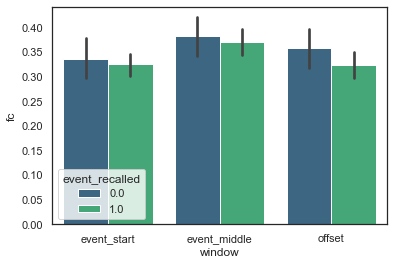

In [28]:
sns.set_theme('notebook')
sns.set_style("white")
sns.barplot(x = 'window', y = 'fc', hue = 'event_recalled', 
            data = boundary_and_nonboundary_encoding_fc_pd[boundary_and_nonboundary_encoding_fc_pd['net1_label']=='PMN'][boundary_and_nonboundary_encoding_fc_pd['delay']=='2'][boundary_and_nonboundary_encoding_fc_pd['event_length']>39],
            order = ['event_start','event_middle','offset'],
           palette = 'viridis')

<AxesSubplot:xlabel='window', ylabel='fc'>

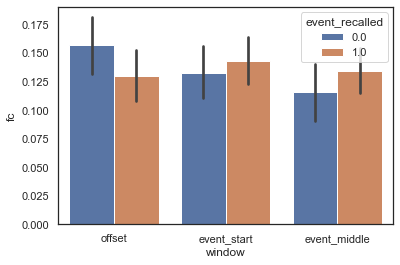

In [668]:
sns.barplot(x = 'window', y = 'fc', hue = 'event_recalled', 
            data = boundary_and_nonboundary_encoding_fc_pd[boundary_and_nonboundary_encoding_fc_pd['delay']=='2'])

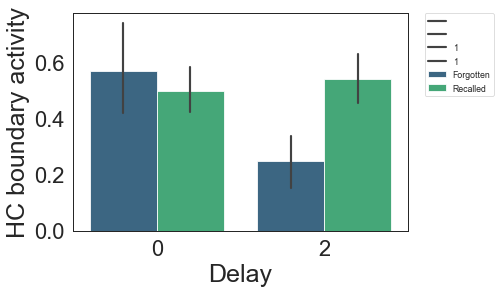

In [408]:
sns.set_palette('viridis',2,1)
sns.barplot(x = 'delay', y = 'boundary_diff', hue = 'event_recalled', data = boundary_and_nonboundary_encoding_fc_pd)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,labels=['','', '1','1','Forgotten','Recalled'])

#modify individual font size of elements
plt.xlabel('Delay', fontsize=25);
plt.ylabel('HC boundary activity', fontsize=25);
plt.tick_params(axis='both', which='major', labelsize=22)

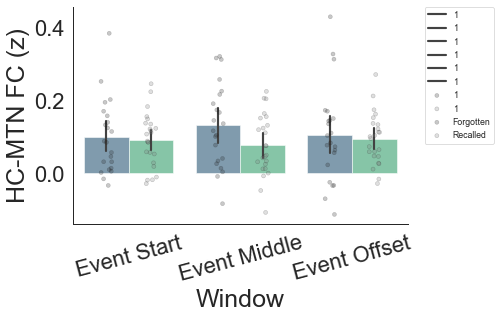

In [409]:
sns.set_theme('paper')
sns.set_style('white')
sns.set_palette('viridis',2,1)
#plt.figure(figsize=(1,5))



data1= boundary_and_nonboundary_encoding_fc_pd.groupby(by = ['subject','window','event_recalled','delay'],as_index=False).mean()
sns.stripplot(x='window', y = 'fc', hue = 'event_recalled',
              data =  data1[data1['event_length']>0][data1['delay']=='0'],
              order=['event_start','event_middle','offset'],dodge=True,linewidth=0.5,alpha=.25,size=4, color = 'gray')

ax = sns.barplot(x='window', y = 'fc', hue = 'event_recalled',
                 data = data1[data1['event_length']>0][data1['delay']=='0'],
                 order=['event_start','event_middle','offset'],alpha= 0.65)
sns.swarmplot
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# set labels
ax.set_xticklabels(['Event Start','Event Middle','Event Offset'],rotation = 15)
ax.set(xlabel='Window', ylabel='HC-PMN FC (z)')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,labels=['1', '1','1','1', '1','1','1','1','Forgotten','Recalled'])

#modify individual font size of elements
plt.xlabel('Window', fontsize=25);
plt.ylabel('HC-MTN FC (z)', fontsize=25);
plt.tick_params(axis='both', which='major', labelsize=22)

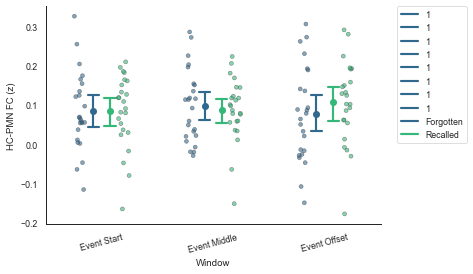

In [412]:
sns.set_palette('viridis',2,1)
data1= boundary_and_nonboundary_encoding_fc_pd.groupby(by = ['subject','window','event_recalled','delay'],as_index=False).mean()
sns.stripplot(x='window', y = 'fc', hue = 'event_recalled',
              data =  data1[data1['event_length']>0][data1['delay']=='2'],
              order=['event_start','event_middle','offset'],dodge=True,linewidth=0.5,alpha=.6,size=4)

ax = sns.pointplot(x='window', y = 'fc', hue = 'event_recalled',
                 data = data1[data1['event_length']>0][data1['delay']=='2'],order=['event_start','event_middle','offset'],
                   join=False,dodge = .15,capsize=.1)
sns.swarmplot
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# set labels
ax.set_xticklabels(['Event Start','Event Middle','Event Offset'],rotation = 15)
ax.set(xlabel='Window', ylabel='HC-PMN FC (z)')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,labels=['1', '1','1','1', '1','1','1','1','Forgotten','Recalled'])

In [475]:
data1= boundary_and_nonboundary_encoding_fc_pd.groupby(by = ['subject','window','event_recalled'],as_index=False).mean()
plot_data = data1

In [476]:
plot_data['event_recalled'] = plot_data['event_recalled'].astype('int').astype('str')

In [477]:
df_test =plot_data.pivot_table(index='subject', columns=['window','event_recalled'],values='fc')

In [484]:
import scipy

In [489]:
scipy.stats.sem(plot_data[plot_data['event_recalled']=='1'][plot_data['window']=='offset']['fc'])

0.014728518115358323

In [467]:
df_test.index

Index(['sub-000', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105',
       'sub-106', 'sub-108', 'sub-109', 'sub-111', 'sub-112', 'sub-115',
       'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-123',
       'sub-124', 'sub-126', 'sub-127', 'sub-128', 'sub-129', 'sub-130'],
      dtype='object', name='subject')

In [468]:
new_cols = [ ('event_start', '0'),
 ('event_start', '1'),
 ('event_middle', '0'),
 ('event_middle', '1'),
 ('offset', '0'),
 ('offset', '1')]

In [469]:
df_test=df_test[new_cols]

In [470]:
jitter = 0.0
df_test_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_test.values.shape), columns=df_test.columns,index =df_test.index )
df_test_jitter += np.arange(len(df_test.columns))/2-.25

In [471]:
df_test_jitter.columns

MultiIndex([( 'event_start', '0'),
            ( 'event_start', '1'),
            ('event_middle', '0'),
            ('event_middle', '1'),
            (      'offset', '0'),
            (      'offset', '1')],
           names=['window', 'event_recalled'])

In [472]:
df_test_jitter[('event_start', '0')]=df_test_jitter[('event_start', '0')]+.05
df_test_jitter[('event_start', '1')]=df_test_jitter[('event_start', '1')]-.05
df_test_jitter[('event_middle', '0')]=df_test_jitter[('event_middle', '0')]+.05
df_test_jitter[('event_middle', '1')]=df_test_jitter[('event_middle', '1')]-.05
df_test_jitter[('offset', '0')]=df_test_jitter[('offset', '0')]+.05
df_test_jitter[('offset', '1')]=df_test_jitter[('offset', '1')]-.05


In [503]:
x_pos = ['event_start','event_start','event_middle','event_middle','offset','offset']
x_pos = np.arange(len(x_pos))

In [504]:
## estimated means from R

#event_recalled = 0:
# window       emmean     SE  df z.ratio p.value
# event_middle 0.0994 0.0166 Inf   6.008  <.0001
# event_start  0.0899 0.0166 Inf   5.433  <.0001
# offset       0.0661 0.0166 Inf   3.994  0.0001##
#
#event_recalled = 1:
# window       emmean     SE  df z.ratio p.value
# event_middle 0.0835 0.0147 Inf   5.673  <.0001
# event_start  0.0919 0.0147 Inf   6.247  <.0001
# offset       0.0989 0.0147 Inf   6.724  <.0001

In [505]:
CTEs = [0.0899,0.0919,0.0994,0.0835,0.0661,0.0989]
error = [0.0166,0.0147,0.0166,0.0147,0.0166,0.0147]

In [507]:
df_test

window         event_middle           event_start              offset  \
event_recalled            0         1           0         1         0   
subject                                                                 
sub-000            0.009824  0.010711    0.046154  0.106423  0.043957   
sub-101            0.113892  0.060937    0.154572  0.124955  0.231051   
sub-102           -0.001800  0.054180    0.098710 -0.000604  0.029106   
sub-103            0.094576  0.078822    0.115088  0.130553  0.150825   
sub-104            0.245373  0.216222    0.256018  0.180338  0.198281   
sub-105            0.092267  0.114131    0.037287  0.048232  0.192760   
sub-106           -0.013964  0.027941    0.036169  0.036477 -0.003755   
sub-108            0.134686  0.105540   -0.043384  0.120173  0.217380   
sub-109            0.121619  0.117790   -0.012035  0.095074 -0.008184   
sub-111            0.054387  0.053450    0.009503  0.029274  0.013191   
sub-112            0.042191 -0.023289    0.037987 -0.046842 -0.029775   
sub-115            0.170837  0.175834    0.084912  0.217035  0.183496   
sub-117           -0.030598 -0.067591   -0.075557 -0.028150 -0.084754   
sub-118            0.038944  0.079614    0.183990  0.121279  0.090442   
sub-119            0.053645  0.145560    0.173608  0.103880  0.155082   
sub-120            0.220987  0.064423    0.116676  0.120032  0.114384   
sub-121            0.217357  0.155616    0.131868  0.139117 -0.019255   
sub-123            0.065748  0.041719    0.085779  0.012282  0.021153   
sub-124            0.139237  0.109970    0.054380  0.085526  0.019327   
sub-126            0.293306  0.131017    0.221330  0.123788  0.140032   
sub-127            0.117653  0.110568    0.059780  0.171090  0.104304   
sub-128            0.147979  0.076834    0.158883  0.197260  0.139035   
sub-129            0.219246  0.179000    0.101256  0.094263  0.079344   
sub-130            0.029629 -0.081803    0.034976 -0.019687 -0.102735   

window                    
event_recalled         1  
subject                   
sub-000         0.097016  
sub-101         0.100325  
sub-102         0.060471  
sub-103         0.192856  
sub-104         0.210790  
sub-105         0.043004  
sub-106         0.018121  
sub-108         0.057284  
sub-109         0.113228  
sub-111         0.055411  
sub-112        -0.002077  
sub-115         0.141445  
sub-117        -0.077808  
sub-118         0.126103  
sub-119         0.080024  
sub-120         0.138331  
sub-121         0.255810  
sub-123         0.087800  
sub-124         0.121816  
sub-126         0.158725  
sub-127         0.149757  
sub-128         0.149382  
sub-129         0.105002  
sub-130         0.038655

In [513]:
df_test_jitter

window         event_start      event_middle      offset     
event_recalled           0    1            0    1      0    1
subject                                                      
sub-000               -0.2  0.2          0.8  1.2    1.8  2.2
sub-101               -0.2  0.2          0.8  1.2    1.8  2.2
sub-102               -0.2  0.2          0.8  1.2    1.8  2.2
sub-103               -0.2  0.2          0.8  1.2    1.8  2.2
sub-104               -0.2  0.2          0.8  1.2    1.8  2.2
sub-105               -0.2  0.2          0.8  1.2    1.8  2.2
sub-106               -0.2  0.2          0.8  1.2    1.8  2.2
sub-108               -0.2  0.2          0.8  1.2    1.8  2.2
sub-109               -0.2  0.2          0.8  1.2    1.8  2.2
sub-111               -0.2  0.2          0.8  1.2    1.8  2.2
sub-112               -0.2  0.2          0.8  1.2    1.8  2.2
sub-115               -0.2  0.2          0.8  1.2    1.8  2.2
sub-117               -0.2  0.2          0.8  1.2    1.8  2.2
sub-118               -0.2  0.2          0.8  1.2    1.8  2.2
sub-119               -0.2  0.2          0.8  1.2    1.8  2.2
sub-120               -0.2  0.2          0.8  1.2    1.8  2.2
sub-121               -0.2  0.2          0.8  1.2    1.8  2.2
sub-123               -0.2  0.2          0.8  1.2    1.8  2.2
sub-124               -0.2  0.2          0.8  1.2    1.8  2.2
sub-126               -0.2  0.2          0.8  1.2    1.8  2.2
sub-127               -0.2  0.2          0.8  1.2    1.8  2.2
sub-128               -0.2  0.2          0.8  1.2    1.8  2.2
sub-129               -0.2  0.2          0.8  1.2    1.8  2.2
sub-130               -0.2  0.2          0.8  1.2    1.8  2.2

In [519]:
idx

'sub-130'

In [520]:
df_test_jitter.loc['sub-000',:].values

array([-0.2,  0.2,  0.8,  1.2,  1.8,  2.2])

In [526]:
colors = ['#414487FF','#22a884FF','#414487FF','#22a884FF','#414487FF','#22a884FF']

<Figure size 72x360 with 0 Axes>

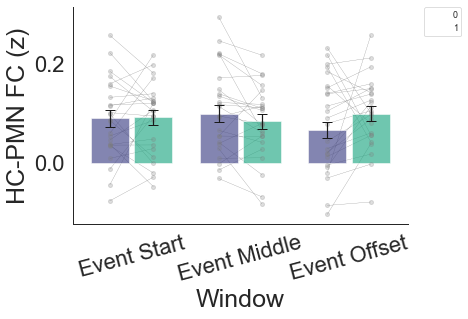

In [536]:
sns.set_theme('paper')
sns.set_style('white')
sns.set_palette('viridis',2,1)
plt.figure(figsize=(1,5))

fig, ax = plt.subplots()
for col in df_test:
    ax.plot(df_test_jitter[col],df_test[col], 'o', alpha=.25, zorder=1, ms=4,
            markeredgewidth=1,markeredgecolor='grey',markerfacecolor='grey')
ax.set_xticks(range(len(df_test.columns)))
ax.set_xticklabels(df_test.columns)
#ax.set_xlim(-0.5,len(df_test.columns)-0.5)


#sns.pointplot(x='window', y = 'fc', hue = 'event_recalled',
#                 data = data1[data1['event_length']>0],scale=.5,errwidth=3,
#                   join=False,dodge = .1,capsize=.05,order=['event_start','event_middle','offset'])

sns.barplot(x = 'window', y = 'fc', hue = 'event_recalled',
           data =plot_data,order=['event_start','event_middle','offset'],alpha = 0,ci=None)

# plot bars and error bars
#ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)

ax.bar(df_test_jitter.loc['sub-000',:].values,CTEs, yerr=error, align='center',
       alpha=0.65, capsize=5, width = .35,color = colors)

for idx in df_test.index:
    ax.plot(df_test_jitter.loc[idx,'event_middle'], df_test.loc[idx,'event_middle'], color = 'grey', linewidth = 0.25, zorder=-1)
    ax.plot(df_test_jitter.loc[idx,'event_start'], df_test.loc[idx,'event_start'], color = 'grey', linewidth = 0.25, zorder=-1)
    ax.plot(df_test_jitter.loc[idx,'offset'], df_test.loc[idx,'offset'], color = 'grey', linewidth = 0.25, zorder=-1)
    
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set labels
ax.set_xticklabels(['Event Start','Event Middle','Event Offset'],rotation = 15)
ax.set(xlabel='Window', ylabel='HC-PMN FC (z)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


#modify individual font size of elements
plt.xlabel('Window', fontsize=25);
plt.ylabel('HC-PMN FC (z)', fontsize=25);
plt.tick_params(axis='both', which='major', labelsize=22)

# get pd for for event details

## total pd and cd recalled in an event

In [1822]:
eventboundary_encoding_fc_recall_pd

,Unnamed: 0,subject,movie,events,delay,fc,net1_label,net2_label,event_label,event_length,percent_events,event_recalled,peri_d,central_d,path_length,true_pd,true_cd
0,0,sub-000,barmaid,1,0,0.291329,VIS,VIS,1,48.0,0.714286,1.0,6.0,4.0,1.995478,5.0,3.5
1,1,sub-000,barmaid,1,0,-0.125273,VIS,SOM-MOT,1,48.0,0.714286,1.0,6.0,4.0,2.571972,5.0,3.5
2,2,sub-000,barmaid,1,0,-0.145123,VIS,SAL1,1,48.0,0.714286,1.0,6.0,4.0,2.587646,5.0,3.5
3,3,sub-000,barmaid,1,0,0.445576,VIS,DAN1,1,48.0,0.714286,1.0,6.0,4.0,1.820428,5.0,3.5
4,4,sub-000,barmaid,1,0,-0.381864,VIS,SAL2,1,48.0,0.714286,1.0,6.0,4.0,2.888138,5.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151195,151195,sub-130,bluestreets,14,0,-0.173646,postHC,MTN,14,89.0,0.854286,1.0,5.5,3.5,2.367175,8.0,4.0
151196,151196,sub-130,bluestreets,14,0,-0.686524,postHC,PMN,14,89.0,0.854286,1.0,5.5,3.5,2.630863,8.0,4.0
151197,151197,sub-130,bluestreets,14,0,-0.137277,postHC,MPN,14,89.0,0.854286,1.0,5.5,3.5,2.330786,8.0,4.0
151198,151198,sub-130,bluestreets,14,0,0.965930,postHC,antHC,14,89.0,0.854286,1.0,5.5,3.5,1.628305,8.0,4.0


In [537]:
model_data1 =eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])

model_data4 =pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data5 = pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data6 = pd.concat([model_data4, model_data5])

model_data7 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='postHC'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data8 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='antHC'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data9 = pd.concat([model_data7, model_data8])

model_data3['window']='offset'
model_data6['window']='event_onset'
model_data9['window']='event_middle'

boundary_and_nonboundary_encoding_fc_details = pd.concat([model_data3,model_data6,model_data9], axis = 0,ignore_index=True)

In [538]:
boundary_and_nonboundary_encoding_fc_details['boundary_diff'] = np.concatenate([boundary_diff_hc,boundary_diff_hc,boundary_diff_hc])
boundary_and_nonboundary_encoding_fc_details['boundary_diff_pmn'] = np.concatenate([boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn,boundary_diff_pmn])
boundary_and_nonboundary_encoding_fc_details['boundary_diff_mtn'] = np.concatenate([boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn,boundary_diff_mtn])
boundary_and_nonboundary_encoding_fc_details['boundary_diff_mpn'] = np.concatenate([boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn,boundary_diff_mpn])
boundary_and_nonboundary_encoding_fc_details['boundary_diff_atn'] = np.concatenate([boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn,boundary_diff_atn])
boundary_and_nonboundary_encoding_fc_details['delay'] = boundary_and_nonboundary_encoding_fc_details['delay'].astype('str')
boundary_and_nonboundary_encoding_fc_details['delay'] = boundary_and_nonboundary_encoding_fc_details['delay'].astype('category')

In [541]:
## mean center boundary diff within Ps
model_data_sub_mean =boundary_and_nonboundary_encoding_fc_details.groupby('subject').mean()
   
boundary_diff_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_details)[0]):
    boundary_diff_mc.append(boundary_and_nonboundary_encoding_fc_details.iloc[i]['boundary_diff'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff'])

boundary_diff_pmn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_details)[0]):
    boundary_diff_pmn_mc.append(boundary_and_nonboundary_encoding_fc_details.iloc[i]['boundary_diff_pmn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_pmn'])
    
boundary_diff_mtn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_details)[0]):
    boundary_diff_mtn_mc.append(boundary_and_nonboundary_encoding_fc_details.iloc[i]['boundary_diff_mtn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_mtn'])

boundary_diff_atn_mc = []
for i in range(np.shape(boundary_and_nonboundary_encoding_fc_details)[0]):
    boundary_diff_atn_mc.append(boundary_and_nonboundary_encoding_fc_details.iloc[i]['boundary_diff_atn'] - model_data_sub_mean.loc[boundary_and_nonboundary_encoding_fc_pd.iloc[i]['subject']]['boundary_diff_atn'])


boundary_and_nonboundary_encoding_fc_details['boundary_diff_mc'] = boundary_diff_mc
boundary_and_nonboundary_encoding_fc_details['boundary_diff_pmn_mc'] = boundary_diff_pmn_mc
boundary_and_nonboundary_encoding_fc_details['boundary_diff_mtn_mc'] = boundary_diff_mtn_mc
boundary_and_nonboundary_encoding_fc_details['boundary_diff_atn_mc'] = boundary_diff_atn_mc


In [172]:
boundary_and_nonboundary_encoding_fc_details.to_csv(analysis_dir+'boundary_and_nonboundary_encoding_fc_details.csv')

In [542]:
model_data3 = boundary_and_nonboundary_encoding_fc_details
model_data3['total_details']=model_data3['central_d']+model_data3['peri_d']
model_data3['total_details_log'] =np.log(model_data3['total_details'])
model_data3 = model_data3[model_data3['total_details']>0]
model_data3['peri_d_log'] =np.log(model_data3['peri_d'])

model_data_sub_mean =model_data3.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data3)[0]):
    fc_mc.append(model_data3.iloc[i]['fc'] - model_data_sub_mean.loc[model_data3.iloc[i]['subject']]['fc'])


model_data3['fc_mc'] =fc_mc



model = smf.mixedlm('total_details_log~fc_mc*delay+fc_mc:delay:window+fc_mc:window+fc_mc:net1_label+fc_mc:net1_label:delay+fc_mc:net1_label:delay:window+event_length+movie+boundary_diff',
                    model_data3,groups = 'subject', missing='drop')
mdf = model.fit(method=['bfgs', 'bfgs', 'cg'])
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             total_details_log
No. Observations:              2721                Method:                         REML             
No. Groups:                    24                  Scale:                          0.3959           
Min. group size:               78                  Likelihood:                     -2661.8960       
Max. group size:               162                 Converged:                      Yes              
Mean group size:               113.4                                                                
----------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept             

In [543]:
model_data3.to_csv(analysis_dir+'boundary_and_nonboundary_encoding_fc_details_neuron_filter.csv')

In [3653]:
mdf.df_resid

2707

In [3654]:
# test the interaction of FC and window
A = np.zeros([len(mdf.params)-1,len(mdf.params)])
A[4,5]=1
A[5,6]=1

In [3655]:
print(mdf.f_test(A))

<F test: F=array([[2.24107607]]), p=0.1065412789262836, df_denom=2.71e+03, df_num=2>


In [3656]:
# test the interaction of FC and window and delay
A = np.zeros([len(mdf.params)-1,len(mdf.params)])
A[7,8]=1
A[8,9]=1


In [3657]:
print(mdf.f_test(A))

<F test: F=array([[6.15184876]]), p=0.0021594311006773045, df_denom=2.71e+03, df_num=2>


In [3658]:
# test the interaction of FC and window and delay and long-axis
A = np.zeros([len(mdf.params)-1,len(mdf.params)])
A[10,11]=1
A[11,12]=1
A[12,13]=1
A[13,14]=1

In [3659]:
print(mdf.f_test(A))

<F test: F=array([[0.48674952]]), p=0.7455033981139625, df_denom=2.71e+03, df_num=4>


### event offset

In [544]:
model_data4 = model_data3.groupby(by = ['subject','window','delay','events','movie'],as_index=False).mean()

model = smf.mixedlm('total_details_log~fc_mc*delay', 
                    model_data4[model_data4['window']=='offset'][model_data4['event_length']>0],
                    groups = 'subject', missing='drop')
mdf = model.fit(method=['bfgs', 'cg'])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 454     Method:             REML             
No. Groups:       24      Scale:              0.4259           
Min. group size:  13      Likelihood:         -474.1599        
Max. group size:  27      Converged:          Yes              
Mean group size:  18.9                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.942    0.079 24.639 0.000  1.787  2.096
delay[T.2]           -0.115    0.062 -1.859 0.063 -0.237  0.006
fc_mc                -0.155    0.213 -0.727 0.467 -0.573  0.263
fc_mc:delay[T.2]      0.447    0.304  1.472 0.141 -0.148  1.043
subject Var           0.108    0.060                           



In [3673]:
mdf.df_resid

450

In [547]:
model_data4 = model_data3.groupby(by = ['subject','window','delay','events','movie'],as_index=False).mean()

model = smf.mixedlm('total_details_log~fc_mc', 
                    model_data3[model_data3['window']=='offset'][model_data3['delay']=='2'],
                    groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())
print(mdf.df_resid)

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 404     Method:             REML             
No. Groups:       24      Scale:              0.4559           
Min. group size:  10      Likelihood:         -437.1005        
Max. group size:  26      Converged:          Yes              
Mean group size:  16.8                                         
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.839    0.081 22.576 0.000  1.679  1.999
fc_mc                 0.212    0.146  1.449 0.147 -0.075  0.498
subject Var           0.130    0.070                           
subject x fc_mc Cov   0.023    0.086                           
fc_mc Var             0.004    0.269                           

402


/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


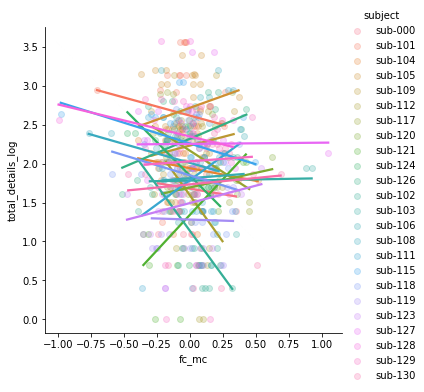

In [209]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'subject', data = model_data3[model_data3['window']=='offset'][model_data3['delay']=='0'],ci = 0,line_kws={'alpha': 1},scatter_kws={'alpha': .25})

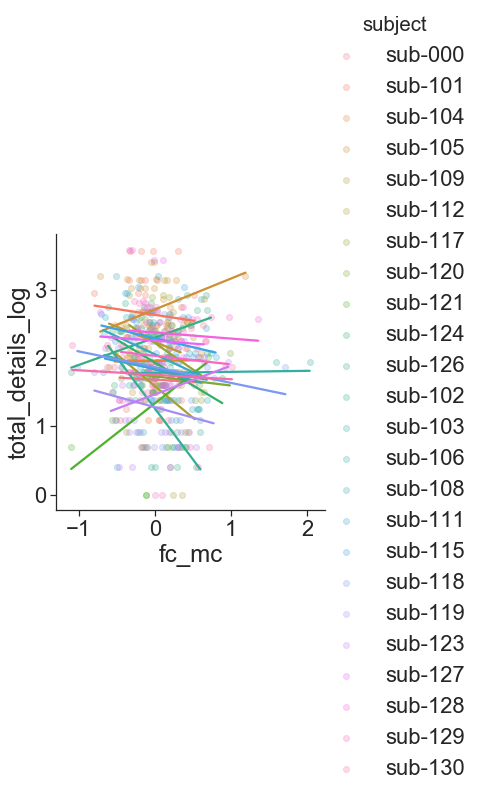

In [3327]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'subject', data = model_data3[model_data3['window']=='offset'][model_data3['delay']=='0'],ci = 0,line_kws={'alpha': 1},scatter_kws={'alpha': .25})

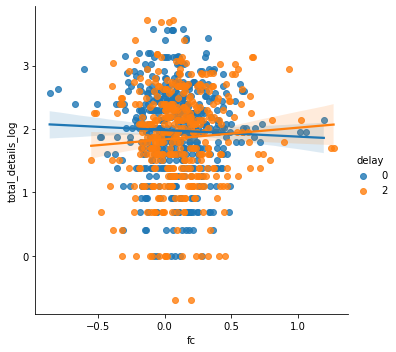

In [211]:
sns.lmplot(x = 'fc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

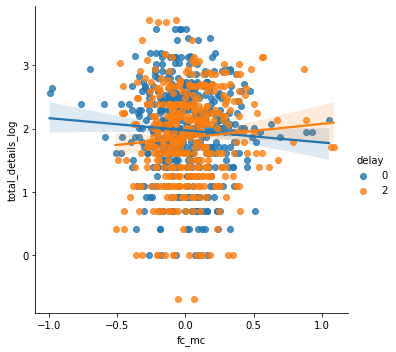

In [214]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

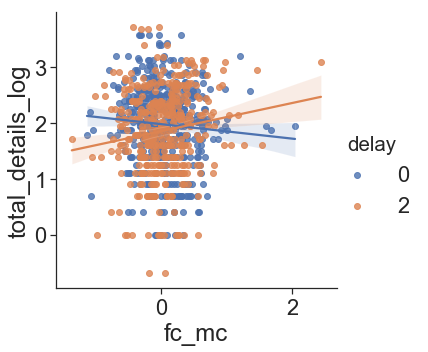

In [1851]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

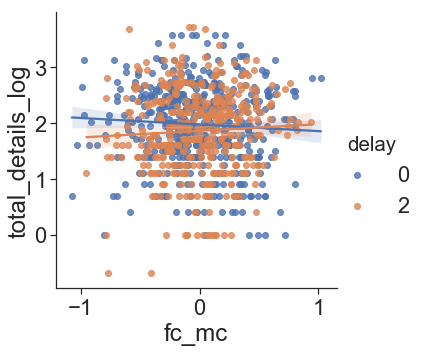

In [1802]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='event_middle'])

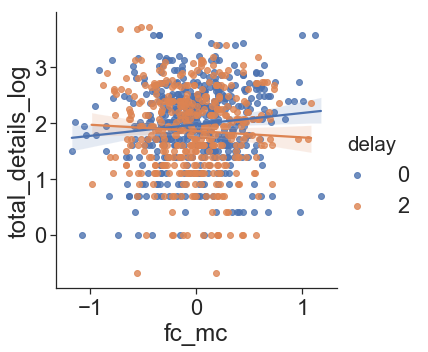

In [1850]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='event_onset'])

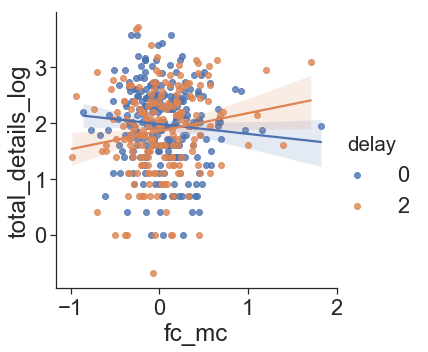

In [1950]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue='delay',
           data = temp[temp['window']=='offset'],)

(0, 3.5)

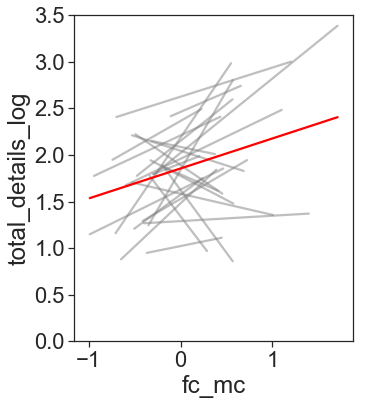

In [1979]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(5, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,scatter=False,
               data = temp[temp['window']=='offset'][temp['delay']=='2'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')

sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')

plt.ylim([0, 3.5])

## onset

(0, 3.5)

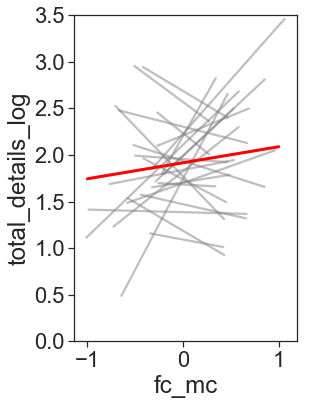

In [2080]:
# immediate recall

temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='event_onset'][temp['delay']=='0'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1],[1.744,2.088],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

(0, 3.5)

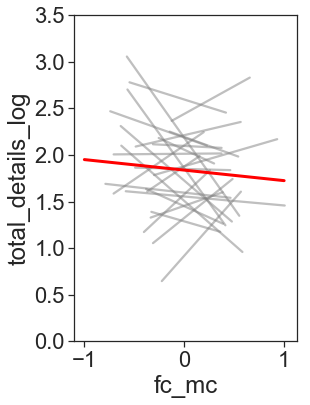

In [2081]:
# delayed recall

temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='event_onset'][temp['delay']=='2'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1],[1.95,1.724],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

## middle

(0, 3.5)

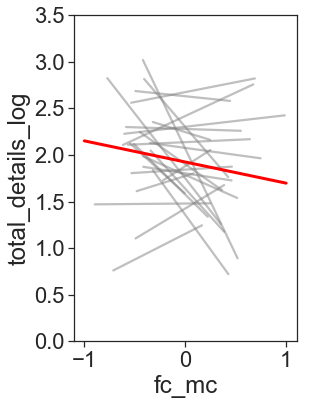

In [2076]:
# immediate recall

temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='event_middle'][temp['delay']=='0'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1],[2.151,1.697],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

(0, 3.5)

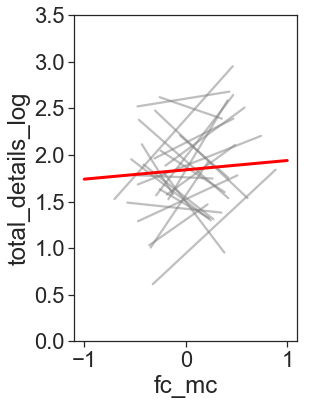

In [2077]:
# delayed recall

temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='event_middle'][temp['delay']=='2'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1],[1.74,1.94],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

## offset

([<matplotlib.axis.XTick at 0x1480deda0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

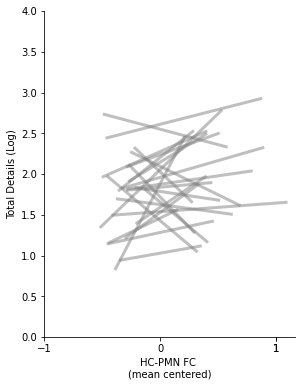

In [217]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4.5, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = model_data3[model_data3['window']=='offset'][model_data3['delay']=='2'][model_data3['subject']==subject_list[sub]],
              line_kws={'alpha': .5,'linewidth':3},scatter_kws={'alpha': .0},color='grey')
#plt.plot([-1,1.672],[1.555,2.3704],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 4])
plt.ylabel('Total Details (Log)')
plt.xlabel('HC-PMN FC \n(mean centered)')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([-1, 0 , 1,1])

Text(0.5,0,'HC-PMN FC \n(mean centered)')

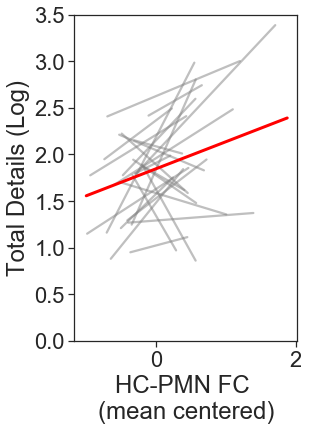

In [2279]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='offset'][temp['delay']=='2'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1.88],[1.555,2.3902],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])
plt.ylabel('Total Details (Log)')
plt.xlabel('HC-PMN FC \n(mean centered)')

(0, 3.5)

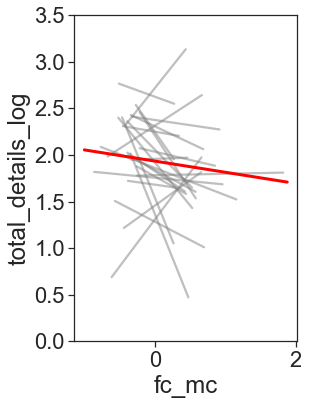

In [2011]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(4, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='offset'][temp['delay']=='0'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')
plt.plot([-1,1.88],[2.054,1.7084],color='red',linewidth=3)
#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='2'],scatter_kws={'alpha': 0},ax=ax,color='red')
plt.ylim([0, 3.5])

In [1968]:
np.max(temp['fc_mc'])

1.8228158320310608

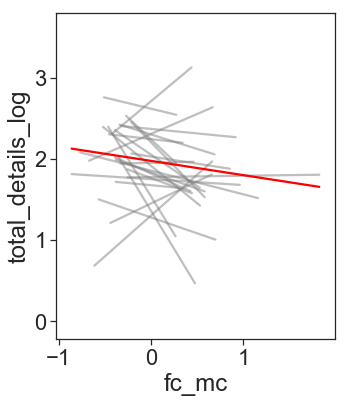

In [1967]:
temp = model_data3.groupby(by=['subject','delay','window','events'],as_index=False).mean()
fig, ax = plt.subplots(figsize=(5, 6))
for sub in range(num_subs):
    sns.regplot(x = 'fc_mc', y = 'total_details_log',ci = 0,
               data = temp[temp['window']=='offset'][temp['delay']=='0'][temp['subject']==subject_list[sub]],
              line_kws={'alpha': .5},scatter_kws={'alpha': .0},color='grey')

#sns.regplot(x = 'fc_mc', y = 'total_details_log',ci=0,
#           data = temp[temp['window']=='offset'][temp['delay']=='0'],scatter_kws={'alpha': 0},ax=ax,color='red')

In [1633]:
model = smf.mixedlm('total_details_log~fc_mc',
                    model_data3[model_data3['window']=='event_onset'][model_data3['delay']=='0']
                    ,groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 504     Method:             REML             
No. Groups:       24      Scale:              0.3214           
Min. group size:  12      Likelihood:         -471.3019        
Max. group size:  28      Converged:          Yes              
Mean group size:  21.0                                         
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.916    0.080 23.894 0.000  1.759  2.073
fc_mc                 0.172    0.125  1.379 0.168 -0.073  0.416
subject Var           0.138    0.083                           
subject x fc_mc Cov   0.002    0.089                           
fc_mc Var             0.241    0.197                           



In [1634]:
model = smf.mixedlm('total_details_log~fc_mc',
                    model_data3[model_data3['window']=='event_onset'][model_data3['delay']=='2']
                    ,groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 404     Method:             REML             
No. Groups:       24      Scale:              0.4501           
Min. group size:  10      Likelihood:         -437.4300        
Max. group size:  26      Converged:          Yes              
Mean group size:  16.8                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.837    0.082 22.506 0.000  1.677  1.997
fc_mc                -0.113    0.108 -1.040 0.298 -0.325  0.100
subject Var           0.131    0.071                           
subject x fc_mc Cov  -0.027    0.066                           
fc_mc Var             0.053    0.122                           



In [1635]:
model = smf.mixedlm('total_details_log~fc_mc*delay',
                    model_data3[model_data3['window']=='event_middle'],groups = 'subject', missing='drop',re_formula='~fc_mc+delay')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  total_details_log
No. Observations:   908      Method:              REML             
No. Groups:         24       Scale:               0.3924           
Min. group size:    26       Likelihood:          -914.3365        
Max. group size:    54       Converged:           Yes              
Mean group size:    37.8                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.926    0.082 23.435 0.000  1.765  2.087
delay[T.2]               -0.088    0.067 -1.328 0.184 -0.219  0.042
fc_mc                    -0.169    0.097 -1.746 0.081 -0.359  0.021
fc_mc:delay[T.2]          0.271    0.129  2.099 0.036  0.018  0.523
subject Var               0.142    0.078                       

In [1636]:
model = smf.mixedlm('total_details_log~fc_mc',
                    model_data3[model_data3['window']=='event_middle'][model_data3['delay']=='0']
                    ,groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 504     Method:             REML             
No. Groups:       24      Scale:              0.3338           
Min. group size:  12      Likelihood:         -476.6396        
Max. group size:  28      Converged:          Yes              
Mean group size:  21.0                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.924    0.082 23.382 0.000  1.763  2.086
fc_mc                -0.227    0.113 -2.004 0.045 -0.449 -0.005
subject Var           0.145    0.085                           
subject x fc_mc Cov   0.031    0.079                           
fc_mc Var             0.155    0.160                           



In [1637]:
model = smf.mixedlm('total_details_log~fc_mc',
                    model_data3[model_data3['window']=='event_middle'][model_data3['delay']=='2']
                    ,groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 404     Method:             REML             
No. Groups:       24      Scale:              0.4518           
Min. group size:  10      Likelihood:         -437.7912        
Max. group size:  26      Converged:          Yes              
Mean group size:  16.8                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.840    0.082 22.489 0.000  1.680  2.000
fc_mc                 0.100    0.119  0.845 0.398 -0.132  0.333
subject Var           0.132    0.071                           
subject x fc_mc Cov  -0.011    0.070                           
fc_mc Var             0.055    0.135                           



In [1638]:
model = smf.mixedlm('total_details_log~fc_mc*delay',
                    model_data3[model_data3['window']=='offset'],groups = 'subject', missing='drop',re_formula='~fc_mc+delay')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  total_details_log
No. Observations:   908      Method:              REML             
No. Groups:         24       Scale:               0.3934           
Min. group size:    26       Likelihood:          -910.6235        
Max. group size:    54       Converged:           Yes              
Mean group size:    37.8                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.934    0.081 23.963 0.000  1.776  2.093
delay[T.2]               -0.100    0.065 -1.550 0.121 -0.226  0.026
fc_mc                    -0.081    0.083 -0.975 0.330 -0.244  0.082
fc_mc:delay[T.2]          0.307    0.108  2.832 0.005  0.094  0.519
subject Var               0.137    0.075                       

In [1700]:
model_data = boundary_and_nonboundary_encoding_fc_details[boundary_and_nonboundary_encoding_fc_details['window']=='offset']
model_data['boundary_diff'] = boundary_diff_hc
model_data['total_details']=model_data['central_d']+model_data['peri_d']
model_data['total_details_log'] =np.log(model_data['total_details'])
model_data = model_data[model_data['total_details']>0]
model_data['peri_d_log'] =np.log(model_data['peri_d'])

model_data_sub_mean =model_data.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data)[0]):
    fc_mc.append(model_data.iloc[i]['fc'] - model_data_sub_mean.loc[model_data.iloc[i]['subject']]['fc'])


model_data['fc_mc'] =fc_mc


model = smf.mixedlm('total_details_log~fc_mc*delay*boundary_diff',
                    model_data,groups = 'subject', missing='drop',re_formula='~fc_mc+delay')
mdf = model.fit(method=['lbfgs', 'bfgs', 'cg'])
print(mdf.summary())

                  Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    total_details_log
No. Observations:     908        Method:                REML             
No. Groups:           24         Scale:                 0.3941           
Min. group size:      26         Likelihood:            -920.5344        
Max. group size:      54         Converged:             Yes              
Mean group size:      37.8                                               
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.935    0.081 23.750 0.000  1.775  2.095
delay[T.2]                     -0.099    0.067 -1.476 0.140 -0.231  0.033
fc_mc                          -0.112    0.090 -1.249 0.212 -0.289  0.064
fc_mc:delay[T.2]                0.336    0.121  2.767 0.

In [ ]:
sns.lmplot(y = 'total_details_log', x = 'fc_mc',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

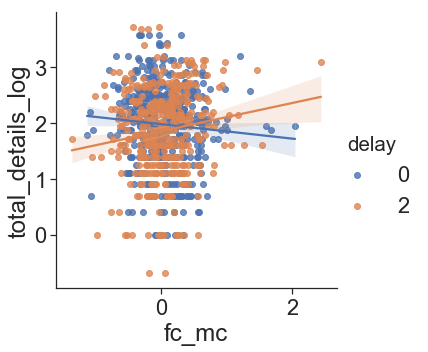

In [1648]:
sns.lmplot(y = 'total_details_log', x = 'fc_mc',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

In [3142]:
sns.lmplot(y = 'total_details_log', x = 'fc_mc',hue = 'delay', data = model_data)

KeyError: "['total_details_log'] not in index"

In [1079]:

model = smf.mixedlm('total_details_log~fc_mc',
                    model_data3[model_data3['window']=='offset'][model_data3['delay']=='0'],groups = 'subject', missing='drop',re_formula='~fc_mc')
mdf = model.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_details_log
No. Observations: 566     Method:             REML             
No. Groups:       24      Scale:              0.1350           
Min. group size:  10      Likelihood:         -274.4152        
Max. group size:  28      Converged:          Yes              
Mean group size:  23.6                                         
-----------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     2.069      0.068   30.589   0.000    1.937    2.202
fc_mc         0.031      0.041    0.762   0.446   -0.049    0.111
subject Var   0.104      0.091                                   



In [1347]:
np.shape(boundary_and_nonboundary_encoding_fc_details)

(4032, 20)

In [1376]:
model_data = boundary_and_nonboundary_encoding_fc_details
model_data['total_details']=model_data['central_d']+model_data['peri_d']
model_data['total_details_log'] =np.log(model_data['total_details'])
model_data = model_data[model_data['window']=='offset']
model_data['boundary_diff']= boundary_diff_hc
model_data = model_data[model_data['total_details']>0]
model_data['peri_d_log'] =np.log(model_data['peri_d'])

model_data_sub_mean =model_data.groupby('subject').mean()
   
fc_mc = []
for i in range(np.shape(model_data)[0]):
    fc_mc.append(model_data.iloc[i]['fc'] - model_data_sub_mean.loc[model_data.iloc[i]['subject']]['fc'])


model_data['fc_mc'] =fc_mc



model = smf.mixedlm('total_details_log~fc_mc*delay+fc_mc:net1_label',
                    model_data,groups = 'subject', missing='drop')
mdf = model.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   total_details_log
No. Observations:   908       Method:               REML             
No. Groups:         24        Scale:                0.4104           
Min. group size:    26        Likelihood:           -919.6223        
Max. group size:    54        Converged:            Yes              
Mean group size:    37.8                                             
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.939    0.076 25.558 0.000  1.790  2.088
delay[T.2]                 -0.106    0.043 -2.468 0.014 -0.191 -0.022
fc_mc                      -0.084    0.096 -0.877 0.381 -0.271  0.103
fc_mc:delay[T.2]            0.325    0.109  2.994 0.003  0.112  0.538
fc_mc:net1_label[T.postHC]  0.023   

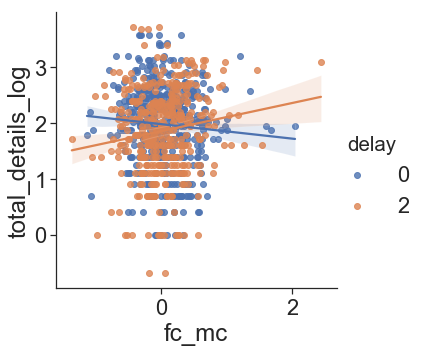

In [1218]:
sns.lmplot(x = 'fc_mc', y = 'total_details_log',hue = 'delay', data = model_data3[model_data3['window']=='offset'])

# which ROIs are contributing to these effects?

In [1205]:
bluestreets_boundaries

array([[  5.        ,  66.47540984, 127.95081967, 190.24590164,
        256.63934426, 317.29508197, 368.93442623, 436.14754098,
        478.7704918 , 550.08196721, 624.67213115, 683.68852459,
        704.18032787, 720.57377049, 809.91803279]])

In [3620]:
## ROI level boundary ~ memory effects
event_list = range(0,14)

# 1. make a roi x hippo x event x subject array
# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay
# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI
# 5. in Matlab (for now) re-label glasser roi cifti files with 
#    stats for visualization (or wait..in PYTHON?! save_t_values_to_cifti.ipynb)


sub_hc_event_fc_z_barmaid = []
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int(np.round(barmaid_boundaries[0,event+1]))-10
        end = int(np.round(barmaid_boundaries[0,event+1]))+10
        event_fc_data = barmaid_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_barmaid.append(hc_event_fc_z)

sub_hc_event_fc_z_bluestreets=[]
for sub in range(num_subs):
    hc_event_fc_z = []
    for event in range(14):
        start = int(np.round(bluestreets_boundaries[0,event+1]))-10
        end = int(np.round(bluestreets_boundaries[0,event+1]))+10
        event_fc_data = bluestreets_movie_fc_data[sub,:,start:end]
        event_fc = np.corrcoef(event_fc_data)
        event_fc_z= np.arctanh(event_fc)
        for x in range(np.shape(event_fc_z)[0]):
            event_fc_z[x,x]=np.nan
        hc_event_fc_z.append(event_fc_z[358:362,:])
    sub_hc_event_fc_z_bluestreets.append(hc_event_fc_z)

sub_hc_event_fc_z = [sub_hc_event_fc_z_barmaid,sub_hc_event_fc_z_bluestreets]    

In [1196]:
int(np.round(barmaid_boundaries[0,0+1]))-10

43

In [1133]:
np.shape(sub_hc_event_fc_z)

(2, 24, 14, 4, 362)

In [3621]:
# 2. for each cell in array, create a df for the fc across participants and events with the associated recall success 
# and delay and details

## df columns = subject, fc, roi_num, hc_roi, recalled, movie, delay, peri_d, central_d, total_details_log

# 3. calculate the effect of fc on recall success and interaction with delay
# 4. save effect statistics for each ROI

hc_roi_list = ['L_ant_hippo','L_post_hipp','R_ant_hippo','R_post_hippo']



subject=[]
events=[]
delay=[]
event_recalled=[]
movie=[]
peri_d=[]
central_d=[]
total_details_log = []


for sub in range(num_subs):
    mov=0
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        subject.append(subject_list[sub])
        events.append(event)
        delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
        event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
        movie.append(movie_list[0])
        peri_d.append(temp2['total pd'].values)
        central_d.append(temp2['total cd'].values)
        

        
for sub in range(num_subs):
    mov=1
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[mov]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        subject.append(subject_list[sub])
        events.append(event)
        delay.append(subjlist_full[subjlist_full['subj_id']==subject_list[sub]][movie_list[mov]+'_delay'].values)
        event_recalled.append(event_boundaries[event_boundaries['subject']==subject_list[sub]][event_boundaries['movie']==movie_list[mov]][event_boundaries['event']==event+1]['recalled'].values)
        movie.append(movie_list[1])        
        peri_d.append(temp2['total pd'].values)
        central_d.append(temp2['total cd'].values)
        
event_recalled = np.reshape(event_recalled,np.shape(event_recalled)[0])
delay = np.reshape(delay,np.shape(delay)[0])
peri_d = np.reshape(peri_d,np.shape(peri_d)[0])
central_d = np.reshape(central_d,np.shape(central_d)[0])
total_details_log = np.log(peri_d+central_d)
total_details_log = np.reshape(total_details_log,np.shape(total_details_log)[0])





In [1208]:
t_values=[]
t_values_inter=[]
t_values_imm=[]
t_values_delay=[]
for roi in range(358):
    fc = []
    for sub in range(num_subs):
        mov=0
        for event in range(14):
            fc.append(np.nanmean(sub_hc_event_fc_z[0][sub][event][:,roi]))        
    for sub in range(num_subs):
        mov=1
        for event in range(14):
            fc.append(np.nanmean(sub_hc_event_fc_z[1][sub][event][:,roi]))

    data_temp = np.transpose([subject,movie,events,delay,fc,event_recalled,total_details_log])
    columns_temp = ['subject','movie','event','delay','fc','event_recalled','total_details_log']
    temp_df =pd.DataFrame(data =data_temp, columns = columns_temp)
    temp_df['fc'] = temp_df['fc'].astype('float')
    temp_df['event_recalled'] = temp_df['event_recalled'].astype('float')
    temp_df['total_details_log'] = temp_df['total_details_log'].astype('float')

    ## event recalled
    #model = smf.mixedlm('event_recalled~fc*delay', temp_df,groups = 'subject', missing='drop')
    #mdf = model.fit()
    #t_values.append(mdf.tvalues[2])
    #t_values_inter.append(mdf.tvalues[3])
    #model = smf.mixedlm('event_recalled~fc', temp_df[temp_df['delay']=='0'],groups = 'subject', missing='drop')
    #mdf = model.fit()
    #t_values_imm.append(mdf.tvalues[1])
    #model = smf.mixedlm('event_recalled~fc', temp_df[temp_df['delay']=='2'],groups = 'subject', missing='drop')
    #mdf = model.fit()
    #t_values_delay.append(mdf.tvalues[1])

    ## total details
            
    temp_df =temp_df[temp_df['total_details_log']>0]
    model = smf.mixedlm('total_details_log~fc*delay', temp_df,groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values.append(mdf.tvalues[2])
    t_values_inter.append(mdf.tvalues[3])
    model = smf.mixedlm('total_details_log~fc', temp_df[temp_df['delay']=='0'],groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values_imm.append(mdf.tvalues[1])
    model = smf.mixedlm('total_details_log~fc', temp_df[temp_df['delay']=='2'],groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values_delay.append(mdf.tvalues[1])


np.save(analysis_dir+'within_subj_fc/t_values_total_details_log'+hc_roi_list[hc_roi]+'.npy',t_values)
np.save(analysis_dir+'within_subj_fc/t_values_inter_total_details_log'+hc_roi_list[hc_roi]+'.npy',t_values_inter)
np.save(analysis_dir+'within_subj_fc/t_values_imm_total_details_log'+hc_roi_list[hc_roi]+'.npy',t_values_imm)
np.save(analysis_dir+'within_subj_fc/t_values_delay_total_details_log'+hc_roi_list[hc_roi]+'.npy',t_values_delay)


In [3622]:
t_values=[]
t_values_inter=[]
t_values_imm=[]
t_values_delay=[]
for roi in range(358):
    fc = []
    for sub in range(num_subs):
        mov=0
        for event in range(14):
            fc.append(np.nanmean(sub_hc_event_fc_z[0][sub][event][:,roi]))        
    for sub in range(num_subs):
        mov=1
        for event in range(14):
            fc.append(np.nanmean(sub_hc_event_fc_z[1][sub][event][:,roi]))

    data_temp = np.transpose([subject,movie,events,delay,fc,event_recalled,total_details_log])
    columns_temp = ['subject','movie','event','delay','fc','event_recalled','total_details_log']
    temp_df =pd.DataFrame(data =data_temp, columns = columns_temp)
    temp_df['fc'] = temp_df['fc'].astype('float')
    temp_df['event_recalled'] = temp_df['event_recalled'].astype('float')
    temp_df['total_details_log'] = temp_df['total_details_log'].astype('float')

    ## event recalled
    model = smf.mixedlm('fc~event_recalled', temp_df,groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values.append(mdf.tvalues[1])
    #t_values_inter.append(mdf.tvalues[3])
    model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='0'],groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values_imm.append(mdf.tvalues[1])
    model = smf.mixedlm('fc~event_recalled', temp_df[temp_df['delay']=='2'],groups = 'subject', missing='drop')
    mdf = model.fit()
    t_values_delay.append(mdf.tvalues[1])


np.save(analysis_dir+'within_subj_fc/t_values_recalled_'+hc_roi_list[hc_roi]+'.npy',t_values)
#np.save(analysis_dir+'within_subj_fc/t_values_recalled_inter'+hc_roi_list[hc_roi]+'.npy',t_values_inter)
np.save(analysis_dir+'within_subj_fc/t_values_recalled_imm'+hc_roi_list[hc_roi]+'.npy',t_values_imm)
np.save(analysis_dir+'within_subj_fc/t_values_recalled_delay'+hc_roi_list[hc_roi]+'.npy',t_values_delay)


In [3639]:
temp_df[temp_df['subject']=='sub-000']

,subject,movie,event,delay,fc,event_recalled,total_details_log
0,sub-000,barmaid,0,0,0.028051,1.0,2.302585
1,sub-000,barmaid,1,0,-0.033302,0.0,-inf
2,sub-000,barmaid,2,0,-0.341945,1.0,2.140066
3,sub-000,barmaid,3,0,-0.755821,1.0,1.704748
4,sub-000,barmaid,4,0,0.681941,1.0,1.098612
5,sub-000,barmaid,5,0,0.221803,1.0,1.609438
6,sub-000,barmaid,6,0,0.614768,1.0,1.098612
7,sub-000,barmaid,7,0,-0.847431,1.0,1.609438
8,sub-000,barmaid,8,0,-0.072082,1.0,1.386294
9,sub-000,barmaid,9,0,0.113210,0.0,-inf


In [1221]:
subject_list

array(['sub-000', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105',
       'sub-106', 'sub-108', 'sub-109', 'sub-111', 'sub-112', 'sub-115',
       'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-123',
       'sub-124', 'sub-126', 'sub-127', 'sub-128', 'sub-129', 'sub-130'],
      dtype=object)

## only true details for the event

In [1809]:
recall_scoring

,subject,movie,event,number of true central details,number of true peripheral details,number of unorganized central details,number of unorganized peripheral details,errors,total cd,total pd,Unnamed: 10
0,sub-000,barmaid,1,3.5,5.0,0.5,1.0,0.0,4.0,6.0,10.0
1,sub-000,barmaid,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sub-000,barmaid,3,3.5,4.0,0.0,1.0,1.5,3.5,5.0,8.5
3,sub-000,barmaid,4,1.0,4.0,0.0,0.5,1.0,1.0,4.5,5.5
4,sub-000,barmaid,5,1.0,1.5,0.0,0.5,0.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
667,sub-130,bluestreets,10,4.0,3.5,0.0,0.0,1.0,4.0,3.5,7.5
668,sub-130,bluestreets,11,4.5,4.0,0.0,0.0,0.0,4.5,4.0,8.5
669,sub-130,bluestreets,12,1.5,0.0,0.0,0.0,0.0,1.5,0.0,1.5
670,sub-130,bluestreets,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1825]:
# need to get all the pd and cd in the same order

event_list = range(0,14)

true_central_d = []
true_peri_d = []


for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[0]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                true_peri_d.append(temp2['number of true peripheral details'].values)
                true_central_d.append(temp2['number of true central details'].values)


event_list = range(0,14)
mov=1  # run bluestreets 
for sub in range(num_subs):
    temp1 = recall_scoring[recall_scoring['subject']==subject_list[sub]][recall_scoring['movie']==movie_list[1]]
    for event in range(14):
        temp2 = temp1[temp1['event']==event+1]
        for net1 in range(np.size(net_label)):
            for net2 in range(np.size(net_label)):
                true_peri_d.append(temp2['number of true peripheral details'].values)
                true_central_d.append(temp2['number of true central details'].values)
   

In [1826]:
np.shape(true_peri_d)

(151200, 1)

In [1827]:
true_peri_d = np.reshape(true_peri_d,np.shape(true_peri_d)[0])
true_central_d = np.reshape(true_central_d,np.shape(true_central_d)[0])

In [1828]:
eventboundary_encoding_fc_recall_pd['true_pd'] = true_peri_d
eventboundary_encoding_fc_recall_pd['true_cd'] = true_central_d

pre_eventboundary_encoding_fc_recall_pd['true_pd'] = true_peri_d
pre_eventboundary_encoding_fc_recall_pd['true_cd'] = true_central_d

nonboundary_encoding_fc_recall_pd['true_pd'] = true_peri_d
nonboundary_encoding_fc_recall_pd['true_cd'] = true_central_d

In [1829]:
model_data1 =eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data2 = eventboundary_encoding_fc_recall_pd[eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']


model_data3 = pd.concat([model_data1, model_data2])

model_data4 =pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='postHC'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data5 = pre_eventboundary_encoding_fc_recall_pd[pre_eventboundary_encoding_fc_recall_pd['net1_label']=='antHC'][pre_eventboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data6 = pd.concat([model_data4, model_data5])

model_data7 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='postHC'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']
model_data8 =nonboundary_encoding_fc_recall_pd[nonboundary_encoding_fc_recall_pd['net1_label']=='antHC'][nonboundary_encoding_fc_recall_pd['net2_label']=='PMN']

model_data9 = pd.concat([model_data7, model_data8])

model_data3['window']='offset'
model_data6['window']='event_onset'
model_data9['window']='event_middle'

boundary_and_nonboundary_encoding_fc_details = pd.concat([model_data3,model_data6,model_data9], axis = 0,ignore_index=True)

In [1830]:
boundary_and_nonboundary_encoding_fc_details['true_cd']=boundary_and_nonboundary_encoding_fc_details['true_cd'].astype('float')
boundary_and_nonboundary_encoding_fc_details['true_pd']=boundary_and_nonboundary_encoding_fc_details['true_pd'].astype('float')